# EdgeFactory : testing computation of edge co-occurences

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)
# http://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
#%load_ext autoreload
#%autoreload 2

# where should we store the figures generated by this notebook
figpath = ''

In [3]:
%cd ../test

/Users/lolo/pool/science/BICV/SparseEdges/test


In [4]:
#! defining framework
#!-------------------
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
mp.pe.N = 4
mp.pe.do_mask = False
mp.pe.MP_alpha = 1.
mp.pe.do_whitening = False
mp.init()

print ('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [ 0.618   0.382   0.2361  0.1459  0.0902  0.0557  0.0344  0.0213  0.0132
  0.0081  0.005 ]


In [5]:
#! this test report is about the MatchingPursuit class:
help(SparseEdges)

Help on class SparseEdges in module SparseEdges.SparseEdges:

class SparseEdges(LogGabor.LogGabor.LogGabor)
 |  Defines a LogGabor framework by defining a ``loggabor`` function which return the envelope of a log-Gabor filter.
 |  
 |  Its envelope is equivalent to a log-normal probability distribution on the frequency axis, and von-mises on the radial axis.
 |  
 |  Method resolution order:
 |      SparseEdges
 |      LogGabor.LogGabor.LogGabor
 |      SLIP.SLIP.Image
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  KL(self, v_hist, v_hist_obs)
 |      # some helper funtion to compare the databases
 |  
 |  __init__(self, pe)
 |      Initializes the SparseEdges class
 |  
 |  adapt(self, edges)
 |  
 |  argmax(self, C)
 |      Returns the ArgMax from C by returning the
 |      (x_pos, y_pos, theta, scale)  tuple
 |      
 |      >>> C = np.random.randn(10, 10, 5, 4)
 |      >>> x_pos, y_pos, theta, scale = mp.argmax(C)
 |      >>> C[x_pos][y_pos][theta][scale] = C.max()


In [6]:
print ('Range of angles: ', mp.theta*180./np.pi)

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]


NOTE: everything below this point should go to another notebook

## Computing edge statistics 

In [7]:
from SparseEdges import SparseEdges

In [8]:
mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
mp.pe.figsize_edges = 12
print (mp.pe)

{'white_recompute': False, 'N_scale': 5, 'white_steepness': 4.0, 'do_mask': True, 'svm_test_size': 0.2, 'svm_max_iter': -1, 'd_max': 2.0, 'do_whitening': True, 'svm_tol': 0.001, 'svm_norm': False, 'N_phi': 12, 'N_image': None, 'datapath': 'database', 'white_f_0': 0.4, 'N_Y': 256, 'MP_alpha': 0.7, 'mask_exponent': 3.0, 'dip_w': 0.2, 'scale': 0.8, 'dip_B_theta': 1.0, 'eta_SO': 0.0, 'scale_circle': 0.08, 'B_theta': 0.17453277777777776, 'svm_n_jobs': 1, 'edge_mask': True, 'N_svm_grid': 32, 'B_sf': 0.4, 'matpath': 'data_cache', 'figsize_hist': 8, 'white_name_database': 'serre07_distractors', 'gamma_range_end': 3, 'seed': 42, 'N': 2048, 'C_range_end': 10.0, 'd_min': 0.5, 'figsize_cohist': 8, 'edgefigpath': 'results/edges', 'white_N': 0.07, 'N_X': 256, 'white_n_learning': 0, 'figsize': 8.0, 'white_N_0': 0.0, 'dip_epsilon': 0.5, 'svm_log': False, 'white_alpha': 1.4, 'MP_rho': None, 'weight_by_distance': True, 'MP_do_mask': True, 'noise': 0.33, 'dip_B_psi': 0.1, 'scale_invariant': True, 'do_ran

In [9]:
mp.pe.n_levels = np.log2(mp.pe.N_X)

### Basics

#### setting up coordinates conventions

cardinal points in X, Y (clockwise):  E (=right=3 o'clock=horizontal), ESE, S, WSW, W, WNW, N, ENE 

In [10]:
X = np.array([0, 1./4, 1./2, 1./4, 0, -1./4, -1./2])#, -1./4])\n",
Y = np.array([1./2, np.sqrt(3)/4, 0, -np.sqrt(3)/4, -1./2, -np.sqrt(3)/4, 0.])#, np.sqrt(3)/
Theta = np.arctan2(-X, Y)
Theta = ((Theta + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
print (Theta* 180./np.pi)

[ -4.7708e-15  -3.0000e+01   9.0000e+01   3.0000e+01  -4.7708e-15
  -3.0000e+01   9.0000e+01]


The X, Y image axis are defined in the matrix style (origin on the upper left; X going vertically down, Y going right horizontally) - the angle is defined as the angle wrt to the horizontal axis :

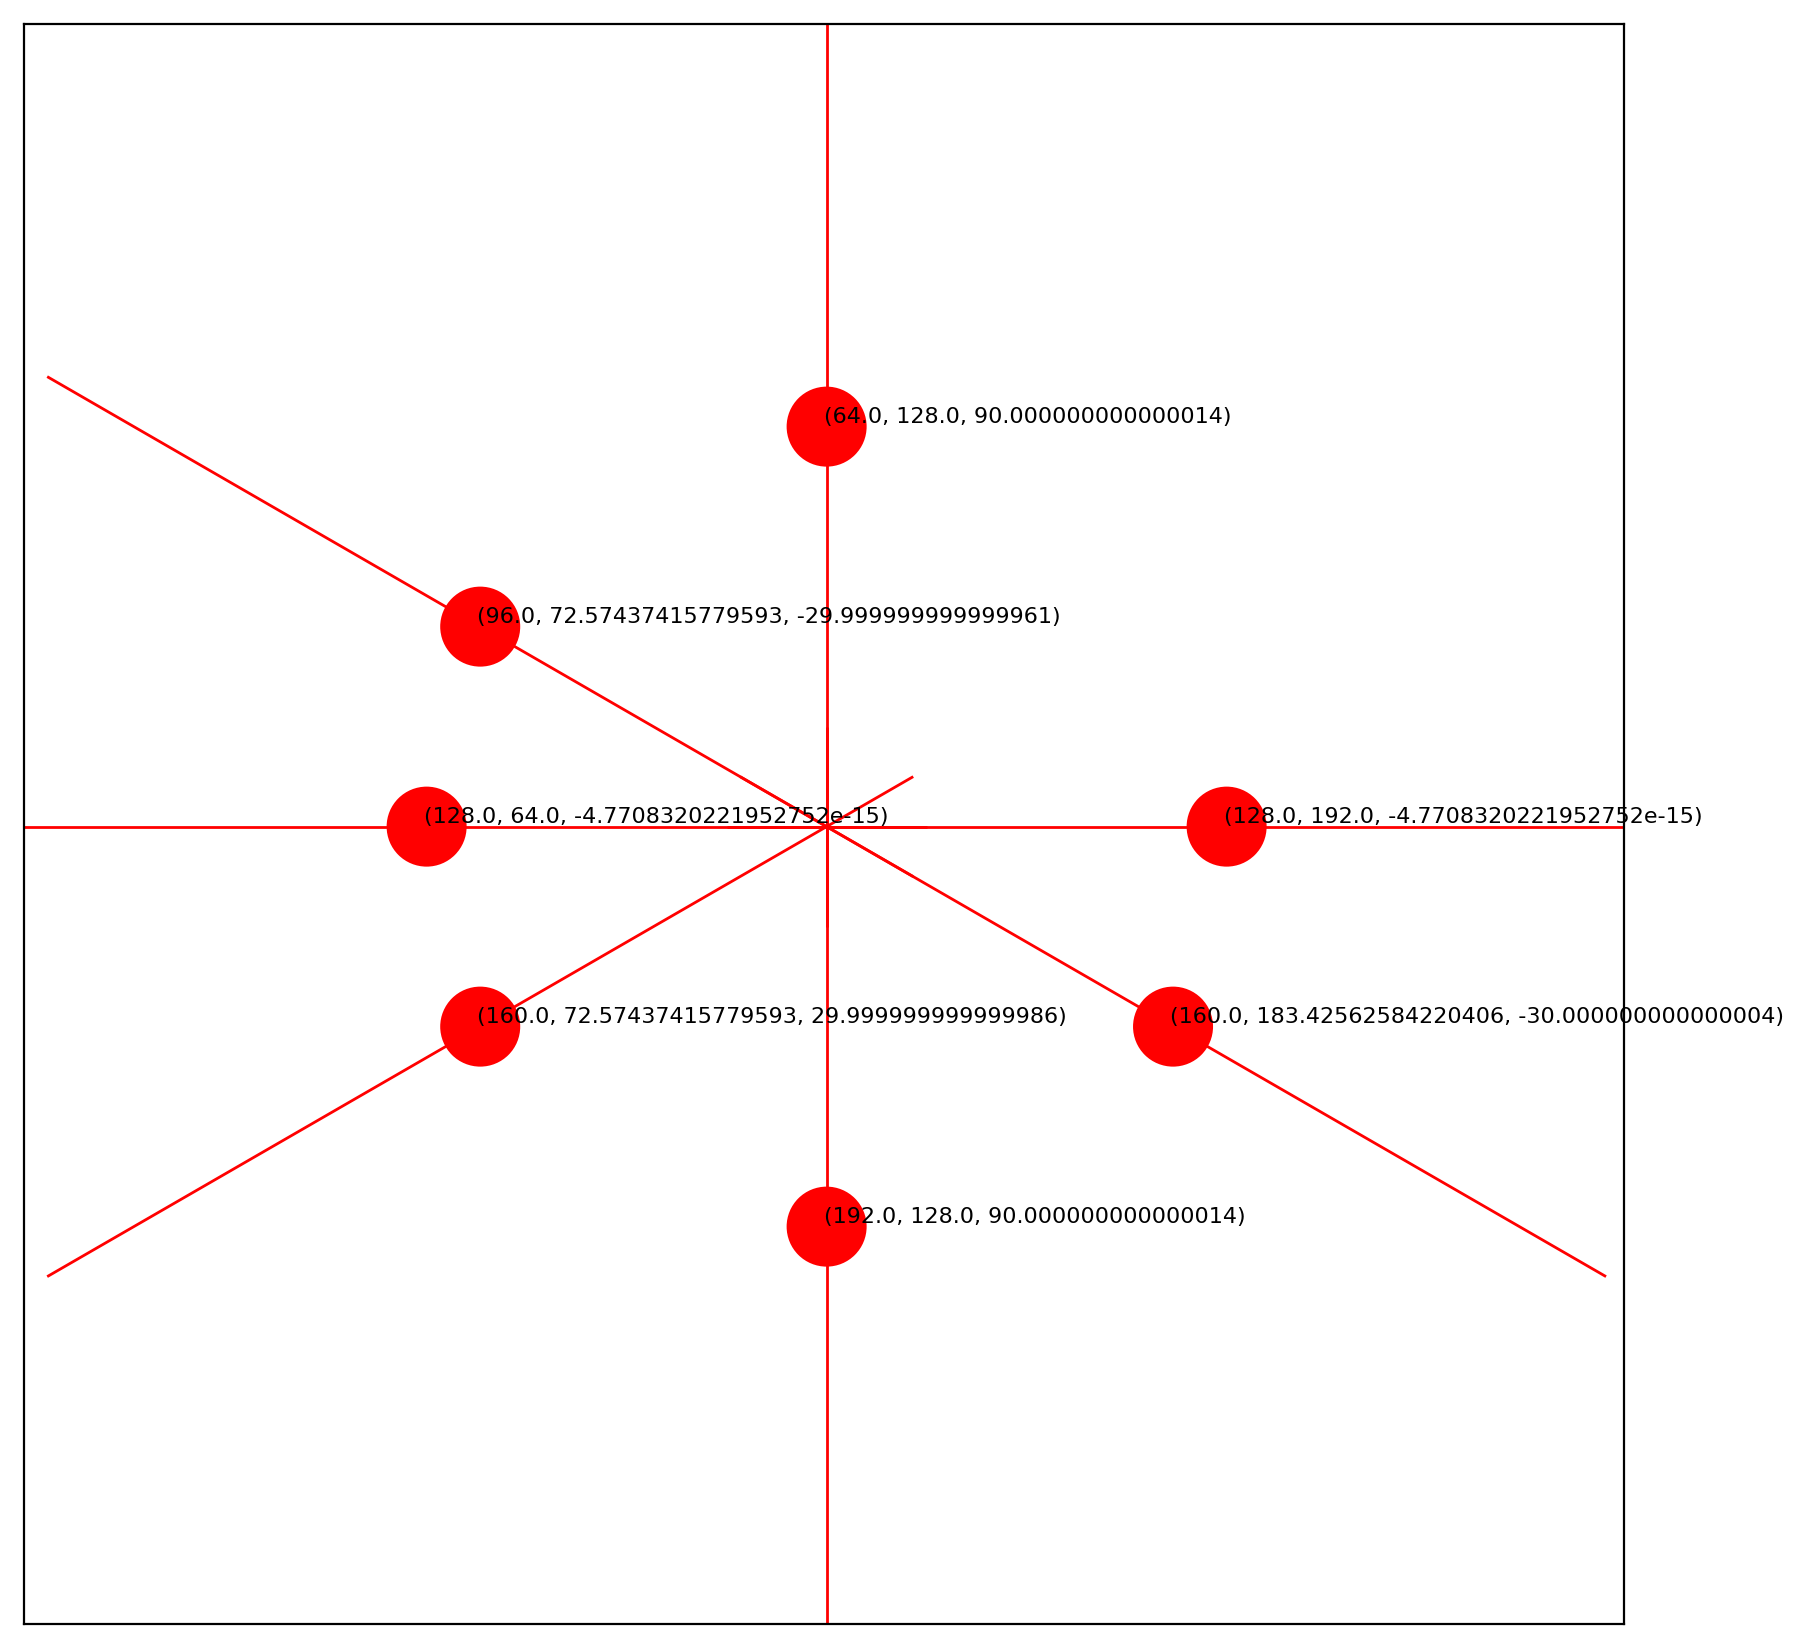

In [11]:
fig, a = mp.show_edges(np.vstack(((X/2. + .5)*mp.pe.N_X, (Y/2. + .5)*mp.pe.N_X, Theta, .01*np.ones(X.shape), np.ones(X.shape), np.zeros(X.shape) )))
t = [a.text(Y_, X_, np.str((X_, Y_, angle*180/np.pi))) for (X_, Y_, angle)  in zip((X/2. + .5)*mp.pe.N_X, (Y/2. + .5)*mp.pe.N_X, Theta)]

#### Testing some angle calculations

coord =  [  64.   64.  192.] [  64.  192.   64.]
angle (CCW wrt horizontal) = [  0.  45.  90.]


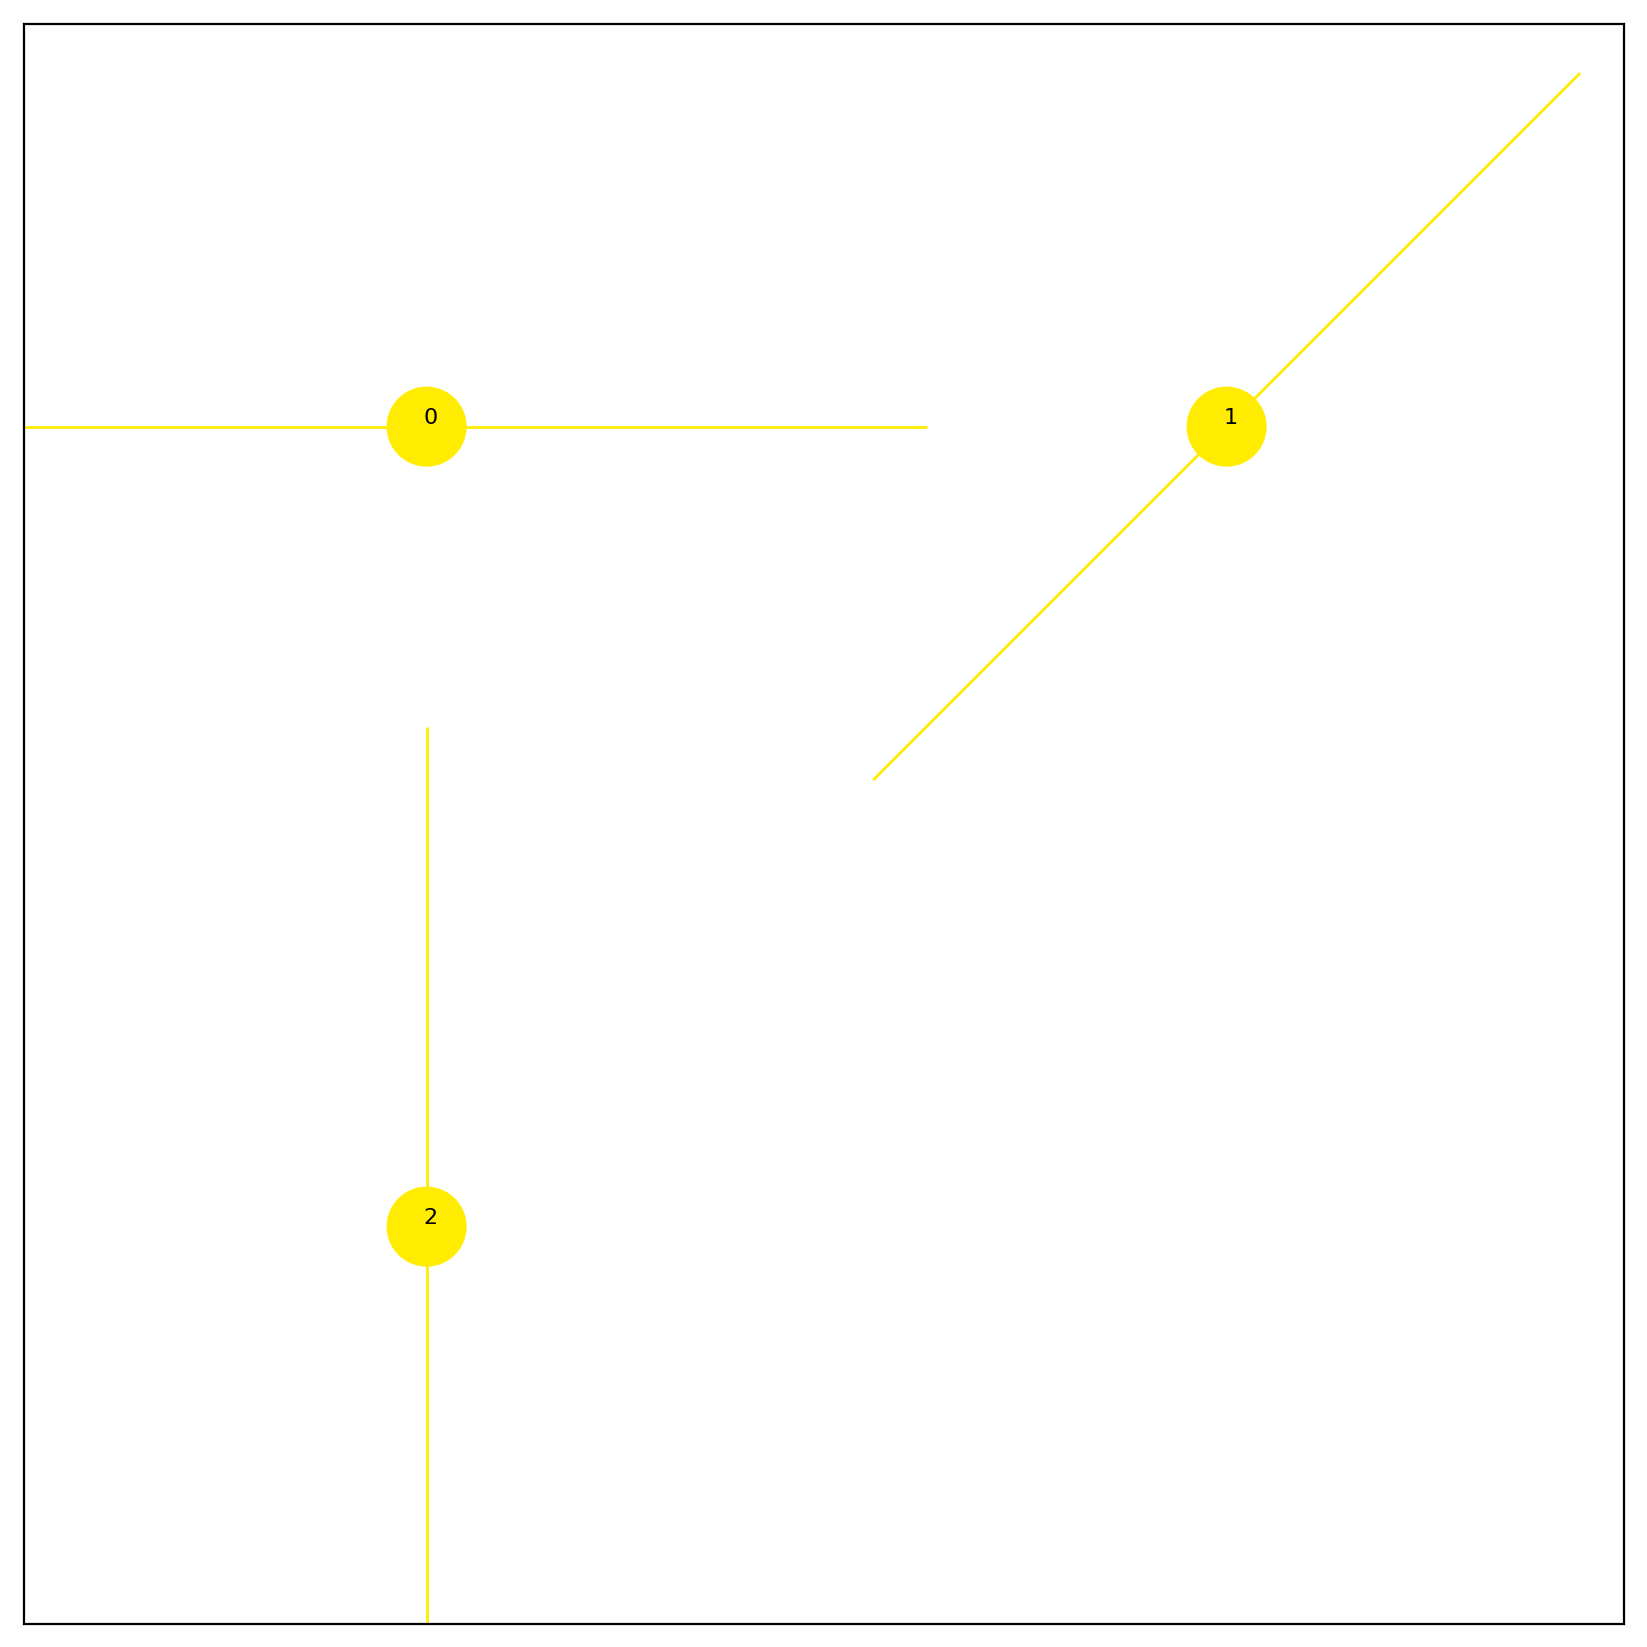

In [12]:
# test points
X = np.array([0.25, 0.25, 0.75])
Y = np.array([0.25, 0.75, 0.25])
X, Y = X*mp.pe.N_X, Y*mp.pe.N_X
print ('coord = ', X, Y)
# by definition, theta = 0 is the horizontal
Theta = np.array([0., np.pi/4, np.pi/2])
print ('angle (CCW wrt horizontal) =', Theta * 180./np.pi)
Sf_0, Weights, Phases = .01*np.ones(X.shape), np.ones(X.shape), np.ones(X.shape)
fig, a = mp.show_edges(np.vstack((X, Y, Theta, Sf_0, Weights, Phases)))
#t = [a.text(Y_, X_, np.str((X_, Y_, '%0.3f ' % (angle*180/np.pi), i))) for (X_, Y_, angle, i)  in zip((X/2. + .5)*N_X, (Y/2. + .5)*N_Y, Theta, range(3))]
t = [a.text(Y_, X_, np.str(i)) for (X_, Y_, i)  in zip(X, Y, range(3))]

#### Relative distance

In [13]:
dx = X[:, np.newaxis] - X[np.newaxis, :]
dy = Y[:, np.newaxis] - Y[np.newaxis, :]
print ('dx_ij = \n', dx, '\n dy_ij = \n', dy)

dx_ij = 
 [[   0.    0. -128.]
 [   0.    0. -128.]
 [ 128.  128.    0.]] 
 dy_ij = 
 [[   0. -128.    0.]
 [ 128.    0.  128.]
 [   0. -128.    0.]]


[ 0.  0.  0.] [   0.  128.  128.]


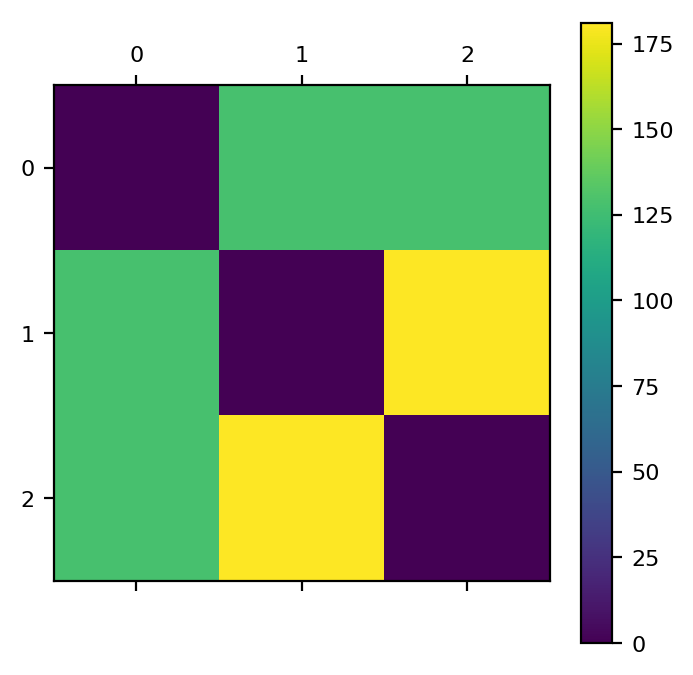

In [14]:
d = np.sqrt(dx**2 + dy**2) #/ pe.N_X * pe.d_width # distance in visual angle
print( np.diag(d), d[0, :])
plt.matshow(d); plt.colorbar()

angle to self =  [ 0.  0.  0.] 
angle from 2 to ...=  [ 90.  45.   0.]
[[  0. -45. -90.]
 [ 45.   0. -45.]
 [ 90.  45.   0.]]


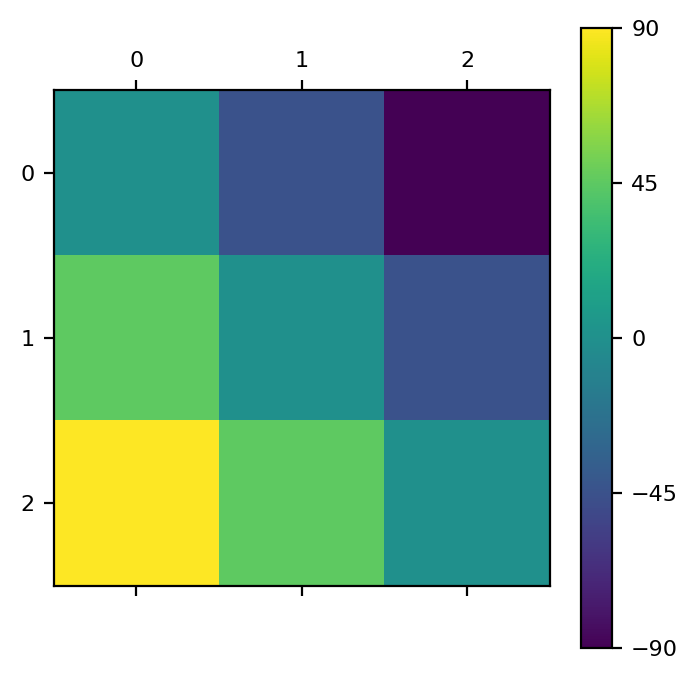

In [15]:
theta = Theta[:, np.newaxis] - Theta[np.newaxis, :]
print ('angle to self = ', np.diag(theta), '\nangle from 2 to ...= ', theta[2, :]*180/np.pi)
plt.matshow(theta*180/np.pi); plt.colorbar(ticks=np.linspace(-90, 90, 5))
print (theta*180/np.pi)

0.0 -45.0 90.0
[[  3.9757e-15  -4.5000e+01   9.0000e+01]
 [  4.5000e+01   3.9757e-15  -4.5000e+01]
 [  9.0000e+01   4.5000e+01   3.9757e-15]]


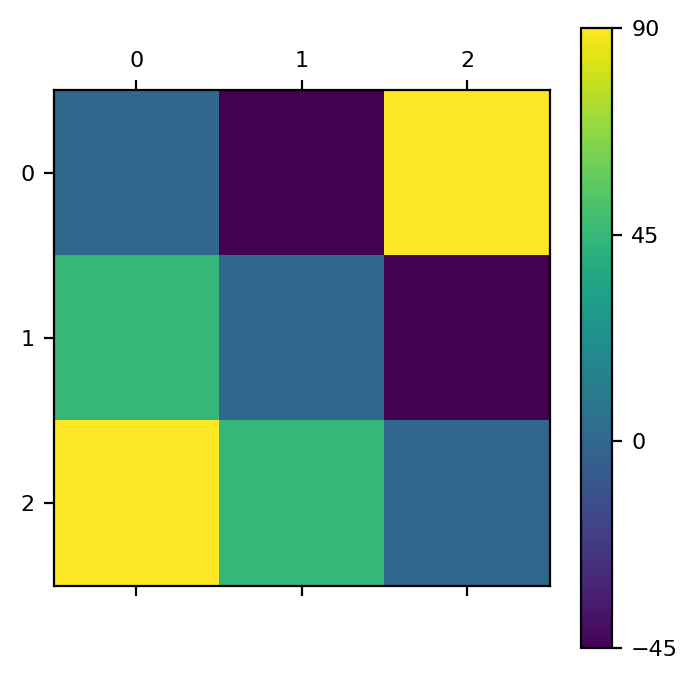

In [16]:
theta = ((theta + np.pi/2 - np.pi/mp.pe.N_Dtheta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.N_Dtheta/2
plt.matshow(theta*180/np.pi); plt.colorbar(ticks=np.linspace(-90, 90, 5))
print (np.diag(theta).std(), theta.min()*180/np.pi, theta.max()*180/np.pi)
print (theta*180/np.pi)

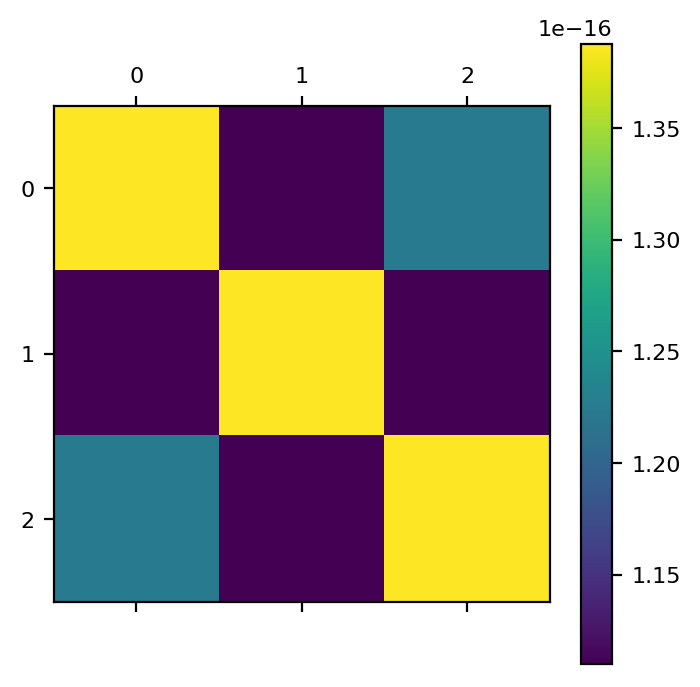

In [17]:
# still anti-symmetric (theta == - theta.T)
plt.matshow(np.sin(theta + theta.T)); plt.colorbar()

phi is the azimuth of the other edge wrt a reference, the matrix gives phi_ij = phi of j wrt i

[[ -90. -180.   90.]
 [   0.  -90.   45.]
 [ -90. -135.  -90.]] [  0.  45.  90.]
[[  nan  135.    0.]
 [   0.   nan  -45.]
 [ -90. -180.   nan]]


/usr/local/lib/python3.5/site-packages/matplotlib/image.py:371: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/usr/local/lib/python3.5/site-packages/matplotlib/image.py:372: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


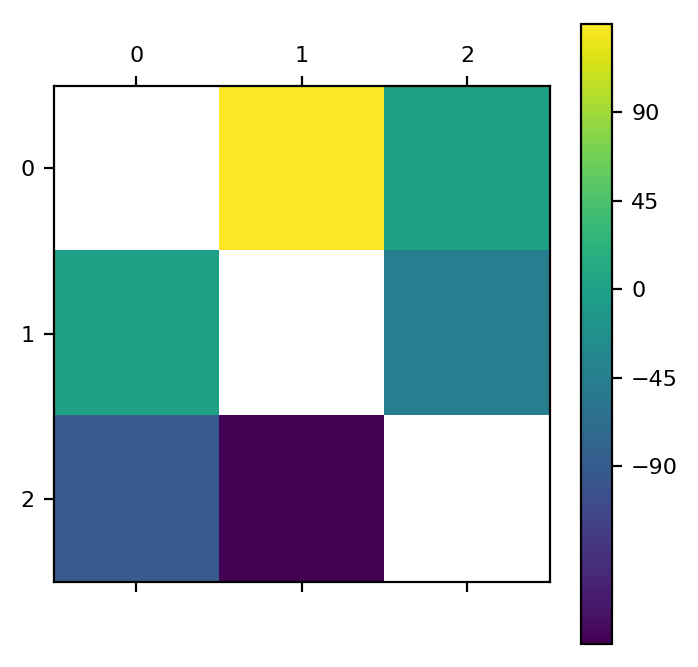

In [18]:
print ((np.arctan2(dy, dx) - np.pi/2)*180/np.pi, Theta*180/np.pi)
#np.seterr(all='ignore')
phi = (np.arctan2(dy, dx) - np.pi/2 - Theta[np.newaxis, :] + np.pi ) % (2*np.pi)  - np.pi
phi += np.diag(np.nan*np.ones(3))
#print np.isnan(phi)
#phi[np.isnan(phi)] = 0.
print( phi*180/np.pi)# np.diag(phi, 1)*180/np.pi, phi[0, :]*180/np.pi
plt.matshow(phi*180/np.pi); plt.colorbar(ticks=np.linspace(-90, 90, 5))

/usr/local/lib/python3.5/site-packages/matplotlib/image.py:371: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/usr/local/lib/python3.5/site-packages/matplotlib/image.py:372: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


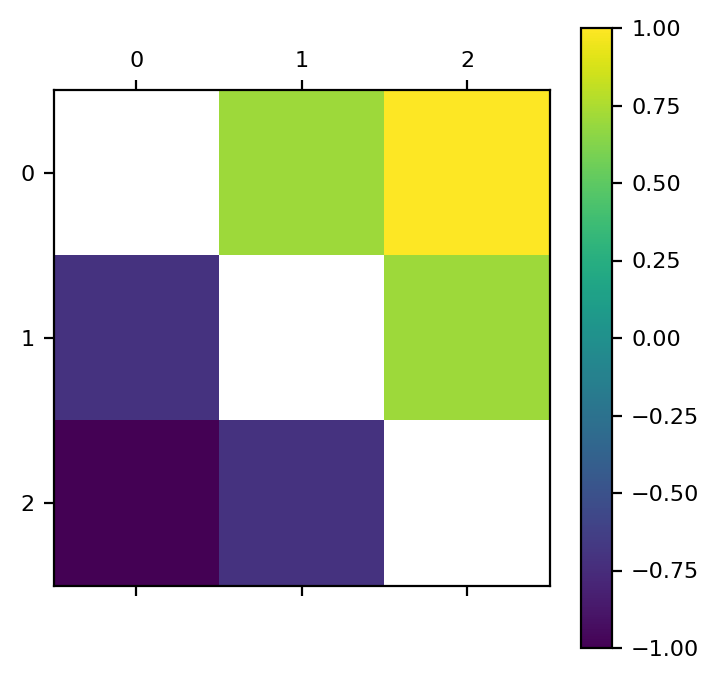

In [19]:
# not symmetric
plt.matshow(np.sin(phi - phi.T)); plt.colorbar()

[[   nan -202.5   45. ]
 [ -22.5    nan  -22.5]
 [-135.  -202.5    nan]]


/usr/local/lib/python3.5/site-packages/matplotlib/image.py:371: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/usr/local/lib/python3.5/site-packages/matplotlib/image.py:372: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


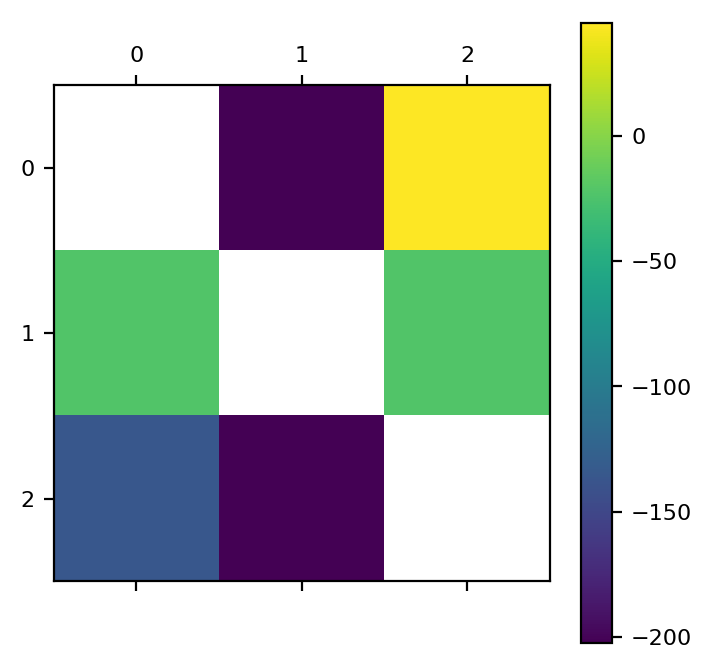

In [20]:
theta = Theta[:, np.newaxis] - Theta[np.newaxis, :]
phi = np.arctan2(dy, dx) - np.pi/2 - Theta[np.newaxis, :]
phi += np.diag(np.nan*np.ones(3))
psi = phi - theta/2
#psi = (Theta[:, np.newaxis]+Theta[np.newaxis, :])/2 + np.arctan2(-dx, dy)# + np.pi/2
print( psi*180/np.pi)#, (psi - (psi + psi.T)/2)*180/np.pi
plt.matshow(psi*180/np.pi); plt.colorbar()

/usr/local/lib/python3.5/site-packages/matplotlib/image.py:371: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/usr/local/lib/python3.5/site-packages/matplotlib/image.py:372: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


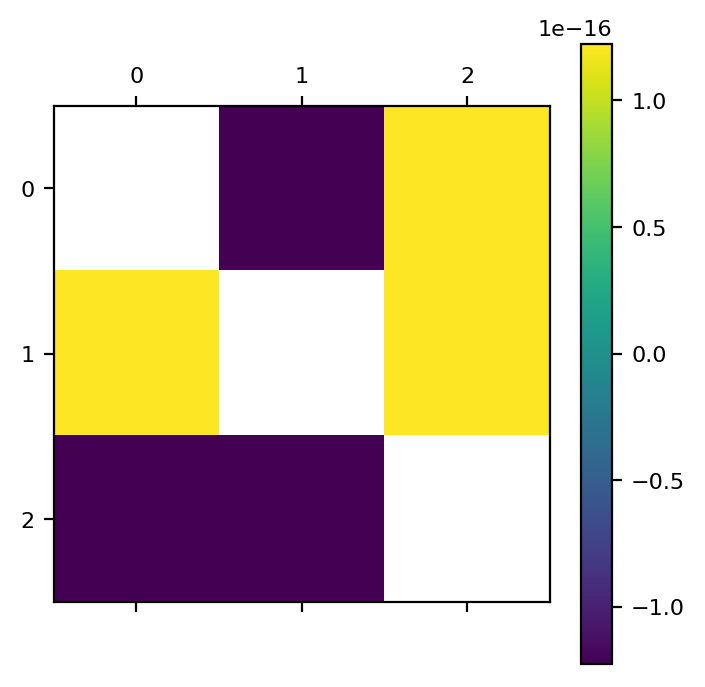

In [21]:
# symmetric
plt.matshow(np.sin(psi - psi.T)); plt.colorbar()

if we assume that an angle occurrence may also happen wrt to its mirror symetric (flipping left and right), then $\psi$ becomes non-oriented

[[  nan -22.5  45. ]
 [-22.5   nan -22.5]
 [ 45.  -22.5   nan]]


/usr/local/lib/python3.5/site-packages/matplotlib/image.py:371: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/usr/local/lib/python3.5/site-packages/matplotlib/image.py:372: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


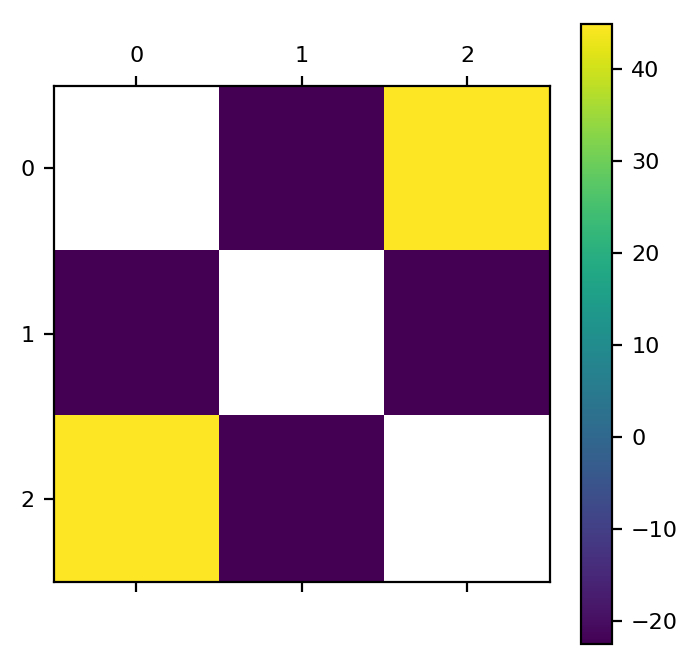

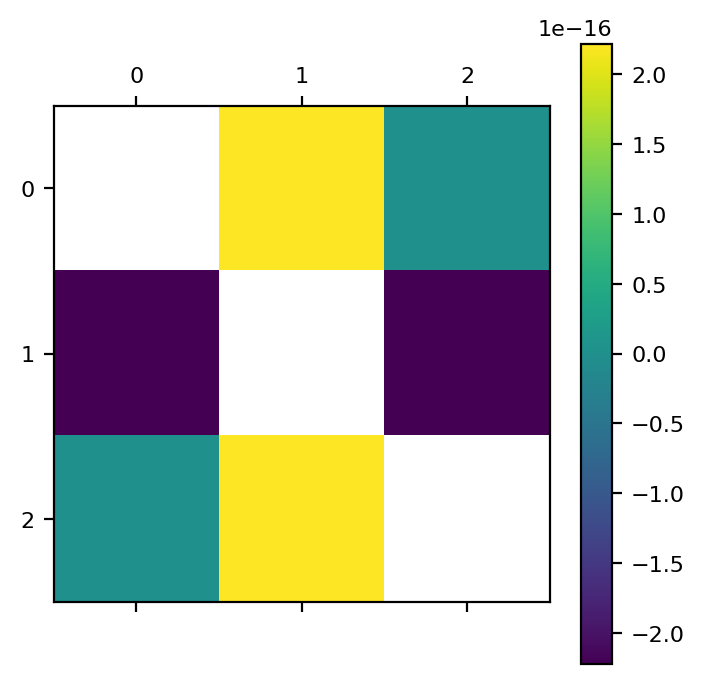

In [22]:
# putting everything in the right range:
psi = ((psi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
print (psi*180/np.pi)
plt.matshow(psi*180/np.pi); plt.colorbar()
#  still symmetric
plt.matshow(psi - psi.T); plt.colorbar()
#print np.sin(psi - psi.T).std()

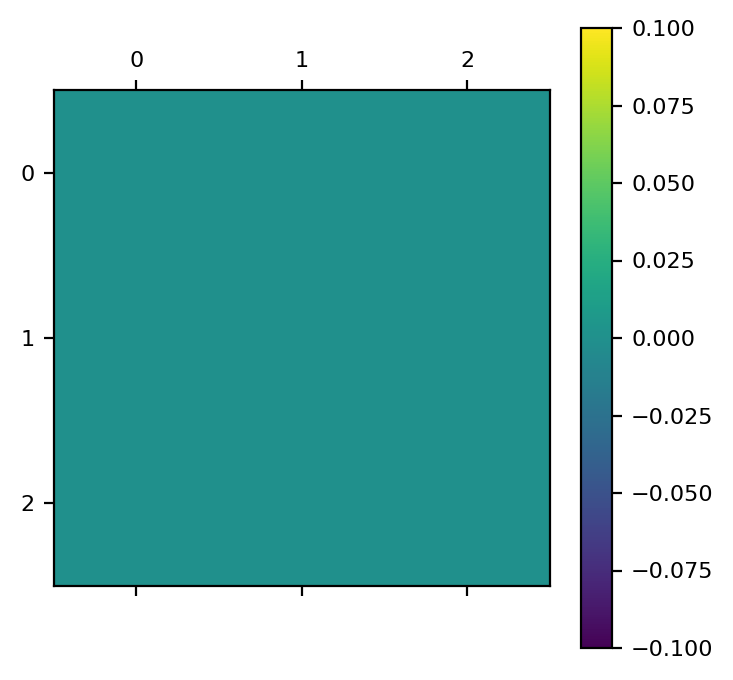

In [23]:
level = np.log2(Sf_0[:, np.newaxis]) - np.log2(Sf_0[np.newaxis, :])
plt.matshow(level); plt.colorbar()

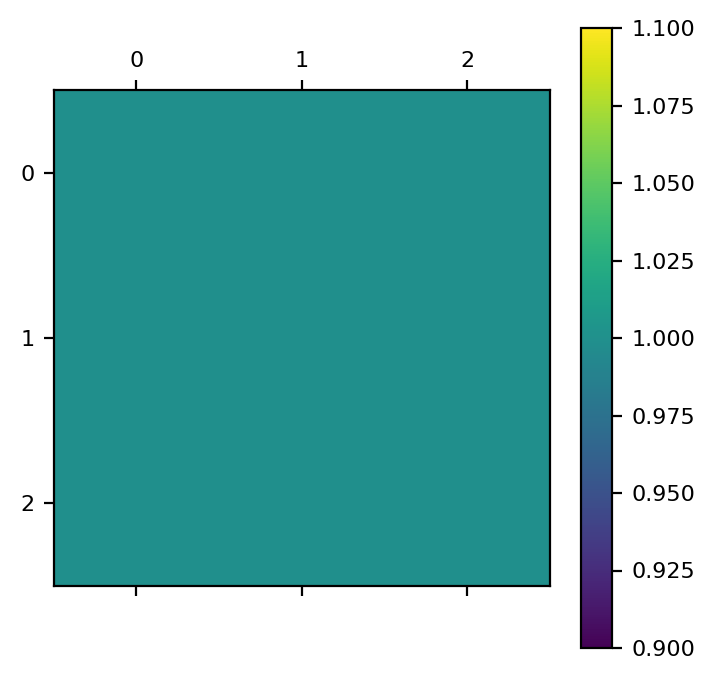

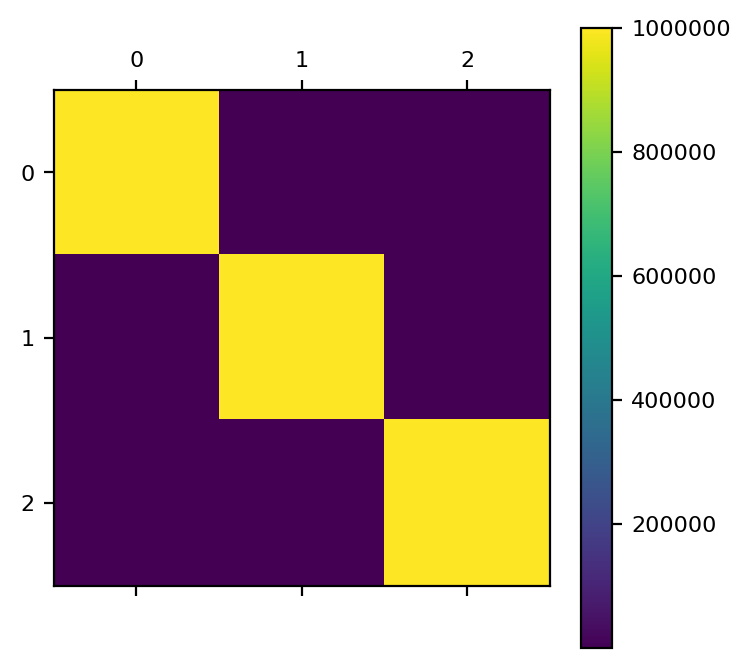

In [24]:
weights = Weights[:, np.newaxis] * Weights[np.newaxis, :]
plt.matshow(weights); plt.colorbar()
weights /= (d + 1.e-6)
plt.matshow(weights); plt.colorbar()

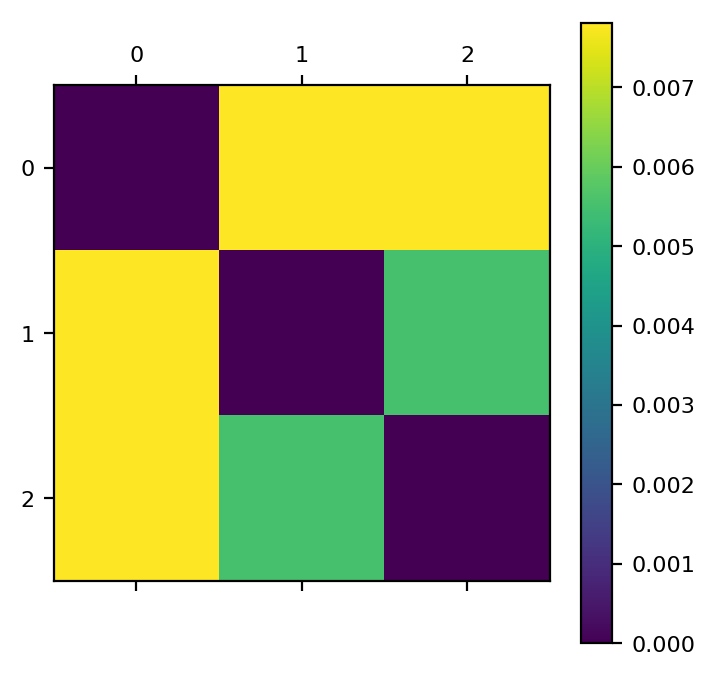

In [25]:
weights[d==0.] = 0. # exclude self-occurence
plt.matshow(weights); plt.colorbar()

### testing the plotting functions using synthetic edge images

In [26]:
help( SparseEdges.histedges_theta)
help( SparseEdges.histedges_scale)
help( SparseEdges.cohistedges)

Help on function histedges_theta in module SparseEdges.SparseEdges:

histedges_theta(self, edgeslist, fig=None, a=None, display=True)
    First-order stats
    
    p(theta | I )

Help on function histedges_scale in module SparseEdges.SparseEdges:

histedges_scale(self, edgeslist, fig=None, a=None, display=True)
    First-order stats for the scale
    
    p(scale | I )

Help on function cohistedges in module SparseEdges.SparseEdges:

cohistedges(self, edgeslist, v_hist=None, prior=None, fig=None, a=None, symmetry=True, display='chevrons', v_min=None, v_max=None, labels=True, mappable=False, radius=None, xticks=False, half=False, dolog=True, color='redblue', colorbar=True, cbar_label=True)
    second-order stats= center all edges around the current one by rotating and scaling
    
    p(x-x_, y-y_, theta-theta_ | I, x_, y_, theta_)



In [27]:
#! a function to display edges
def myplot(edgeslist, mp):

    fig = plt.figure(figsize=(9, 12))
    a1 = fig.add_subplot(321)
    fig, a = mp.show_edges(edgeslist[:, :, 0], image=np.ones((mp.pe.N_X, mp.pe.N_X)), fig=fig, a=a1)
    a2 = fig.add_subplot(322)
    fig, a2 = mp.histedges_scale(edgeslist, fig=fig, a=a2)
    a3 = fig.add_subplot(323, polar=True)
    fig, a3 = mp.histedges_theta(edgeslist, fig=fig, a=a3)
    a4 = fig.add_subplot(324)
    v_hist = mp.cohistedges(edgeslist, display='none')
    v_hist_nosym = mp.cohistedges(edgeslist, display='none', symmetry=False)
    fig, a4 = mp.cohistedges(edgeslist=None, v_hist=v_hist, fig=fig, a=a4)
    a5 = fig.add_subplot(325)
    fig, a5 = mp.cohistedges(edgeslist=None, v_hist=v_hist_nosym, fig=fig, a=a5, symmetry=False, display='colin_geisler')
    a6 = fig.add_subplot(326)
    fig, a6 = mp.cohistedges(edgeslist=None, v_hist=v_hist_nosym, fig=fig, a=a6, symmetry=False, display='cocir_geisler')
    #plt.tight_layout()
    plt.show()
    fig2 = plt.figure(figsize=(9, 9))
    fig2, a1, a2, a3, a4 = mp.cohistedges(edgeslist=None, v_hist=v_hist, fig=fig2, display='full')
    return v_hist

#### Just with 2 edges and  averaged over N_images trials

/usr/local/lib/python3.5/site-packages/numpy/lib/function_base.py:812: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


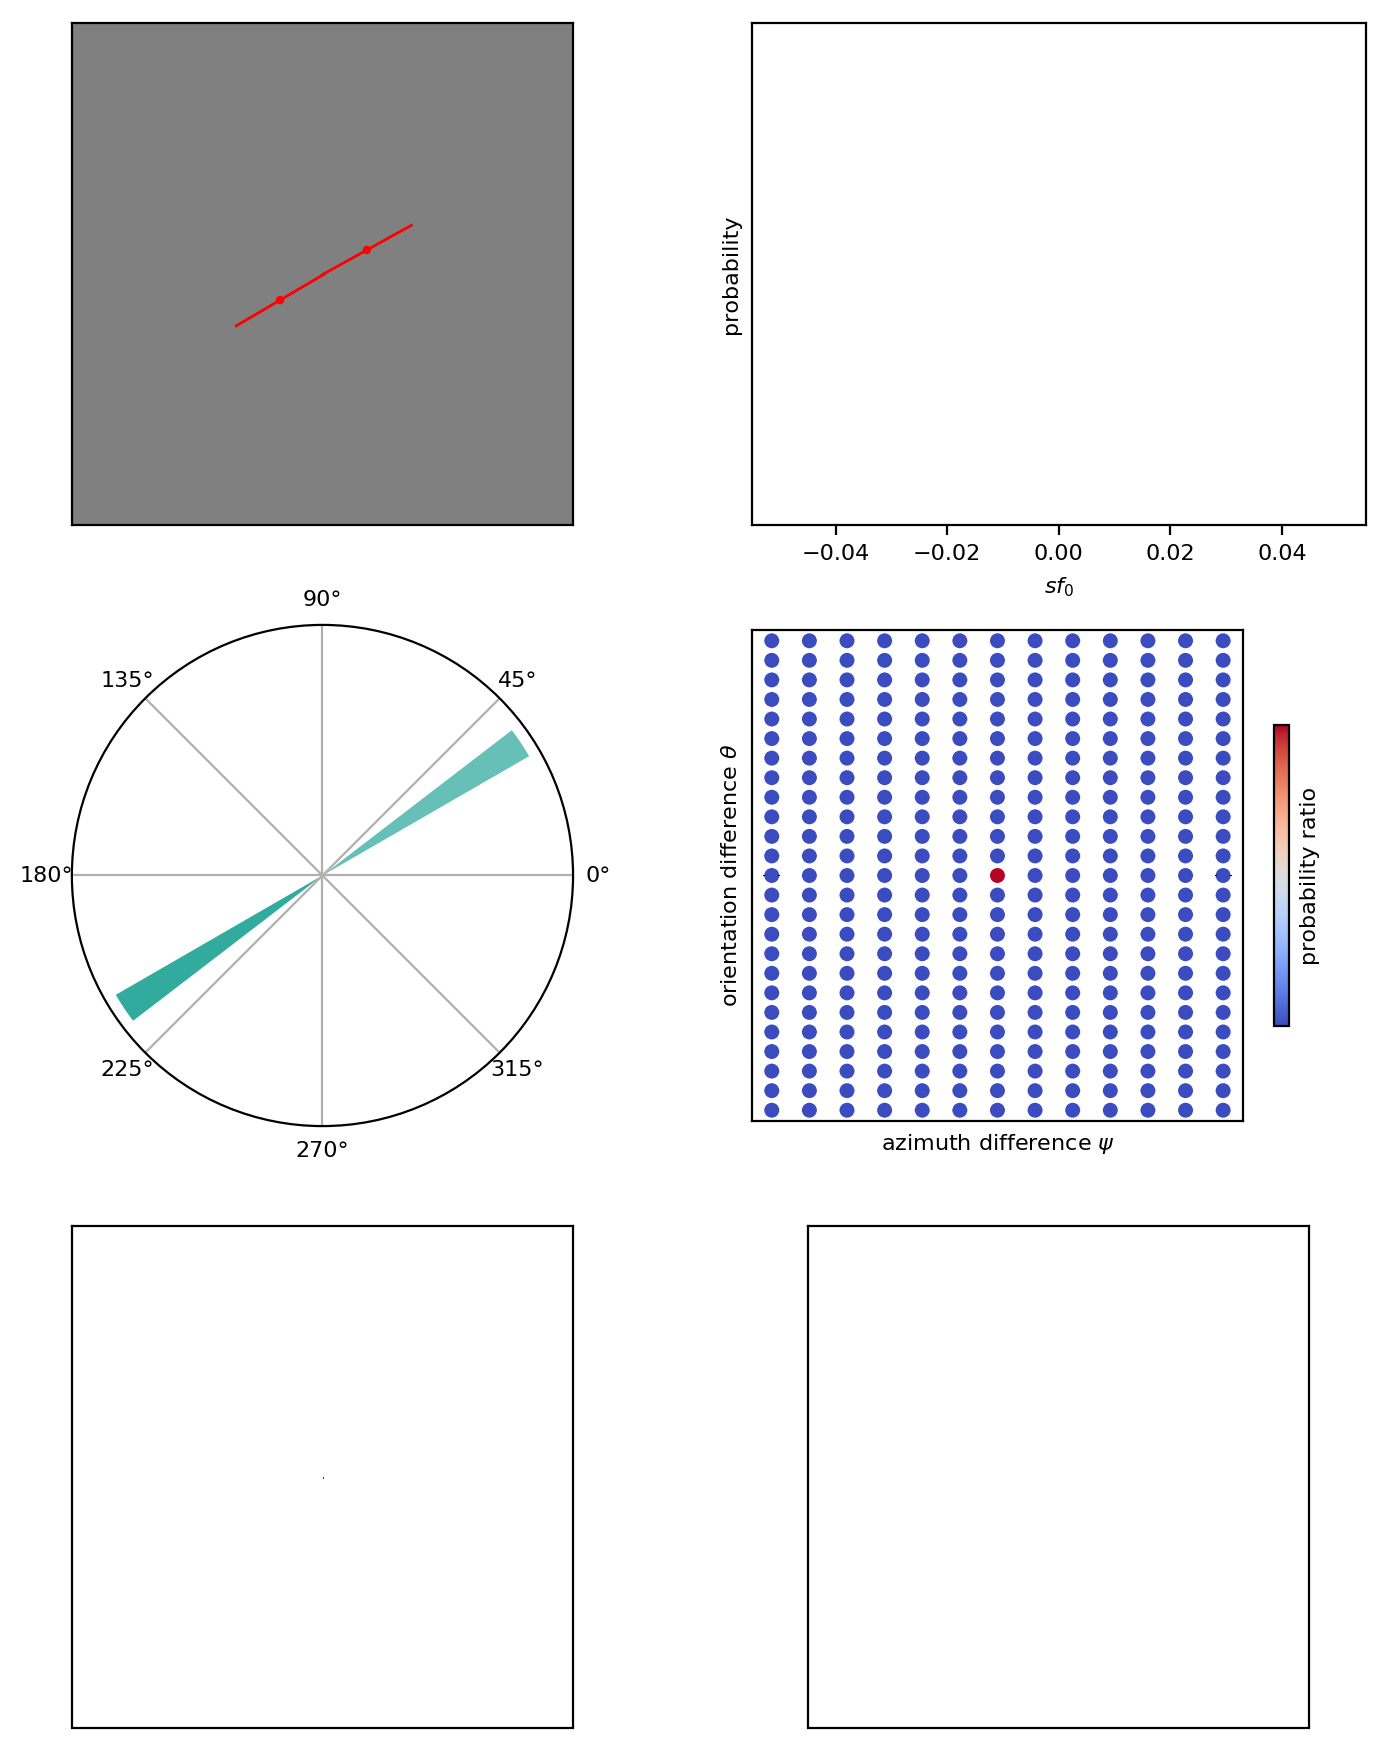

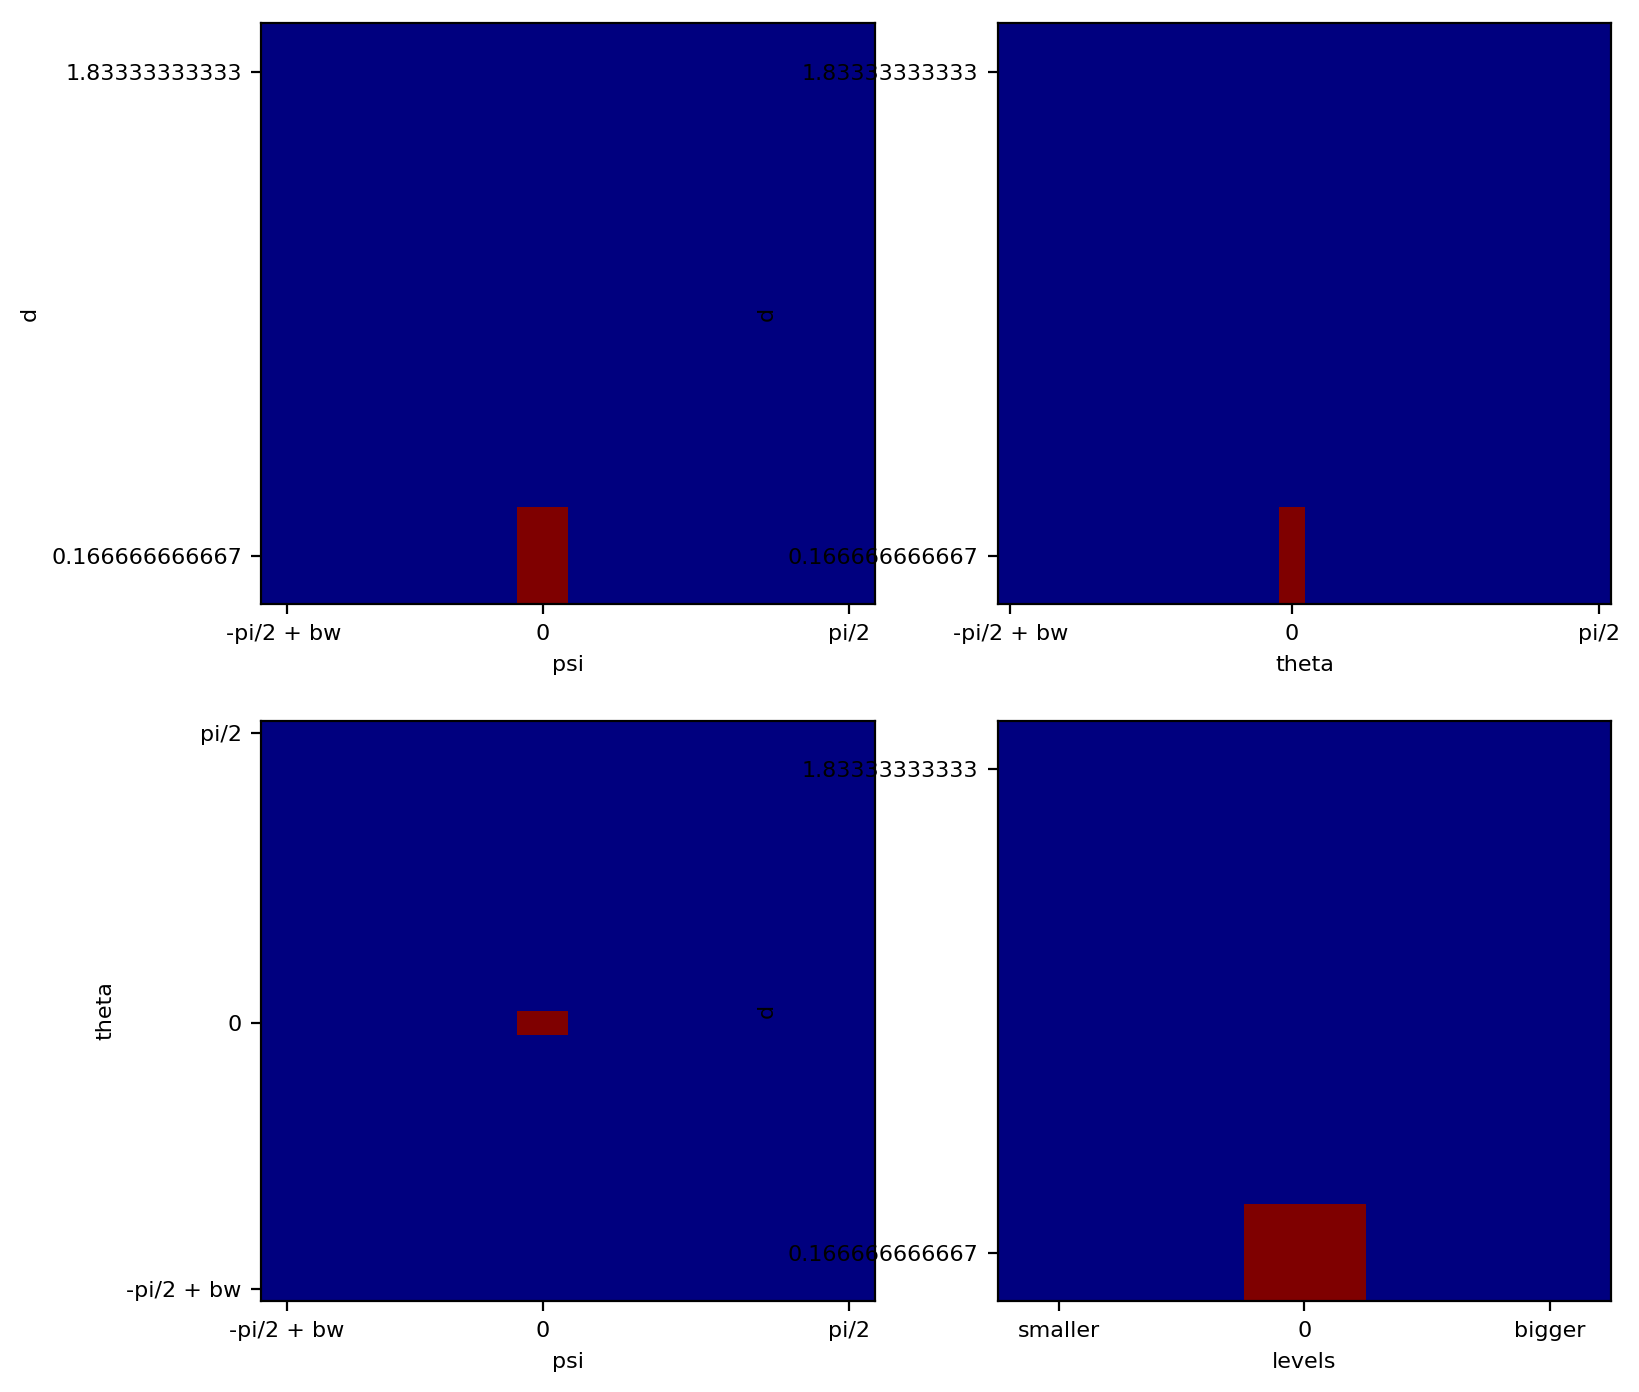

In [28]:
mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
mp.pe.N_image = 20
mp.pe.d_max = 2.
mp.pe.d_min = 0.
edgeslist = np.zeros((6, 2, mp.pe.N_image))
angle = np.pi/6
for i_N, sign in enumerate([-1., 1.]):
    edgeslist[0, i_N, :] = mp.pe.N_X *(1/2. + .1 * np.sin(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.pe.N_X *(1/2. - .1 * np.cos(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (angle + np.pi/360.* np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = .03
    edgeslist[4, i_N, :] = 1.
#print  edgeslist
v_hist = myplot(edgeslist, mp=mp)
#print v_hist

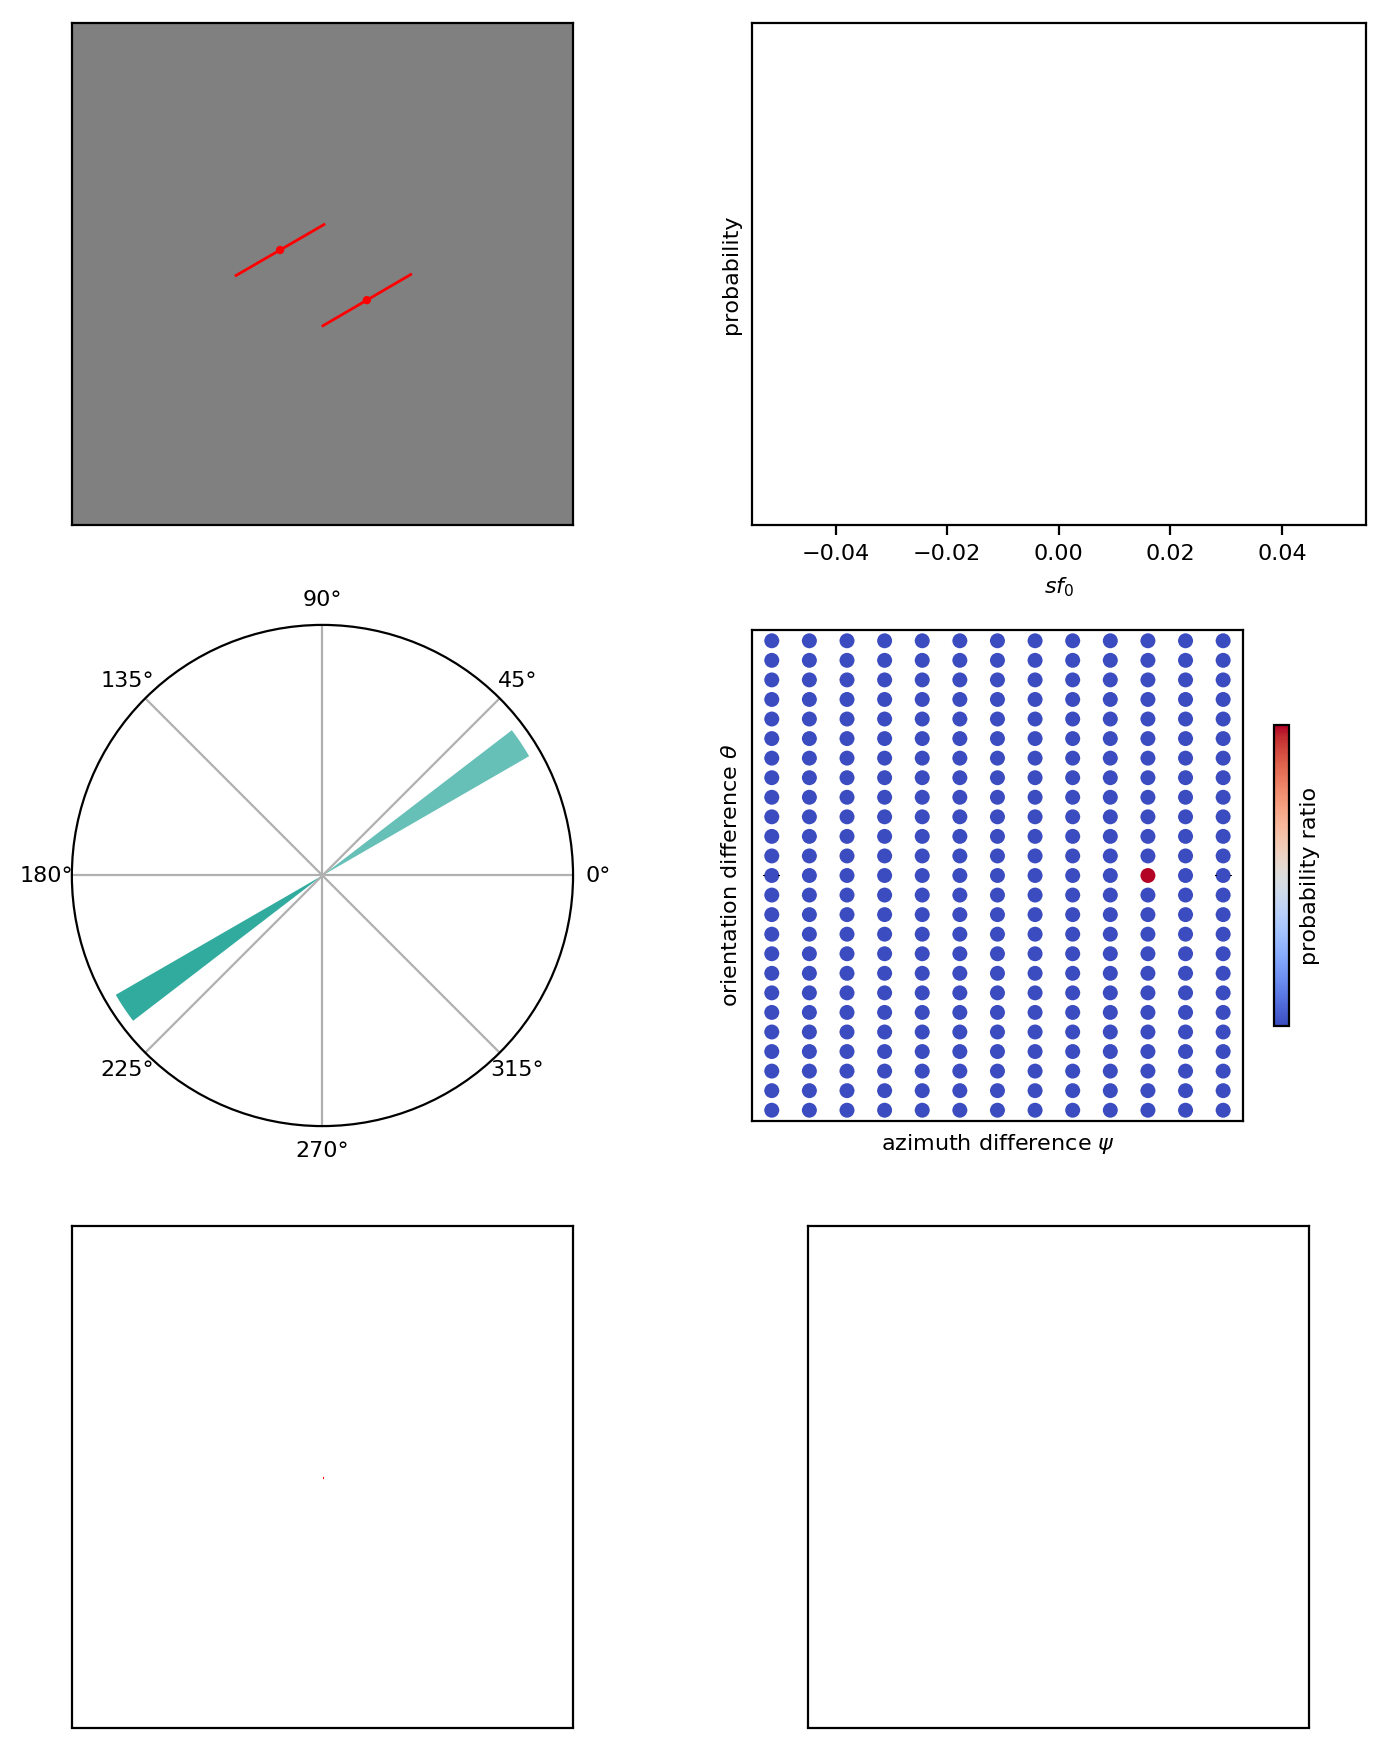

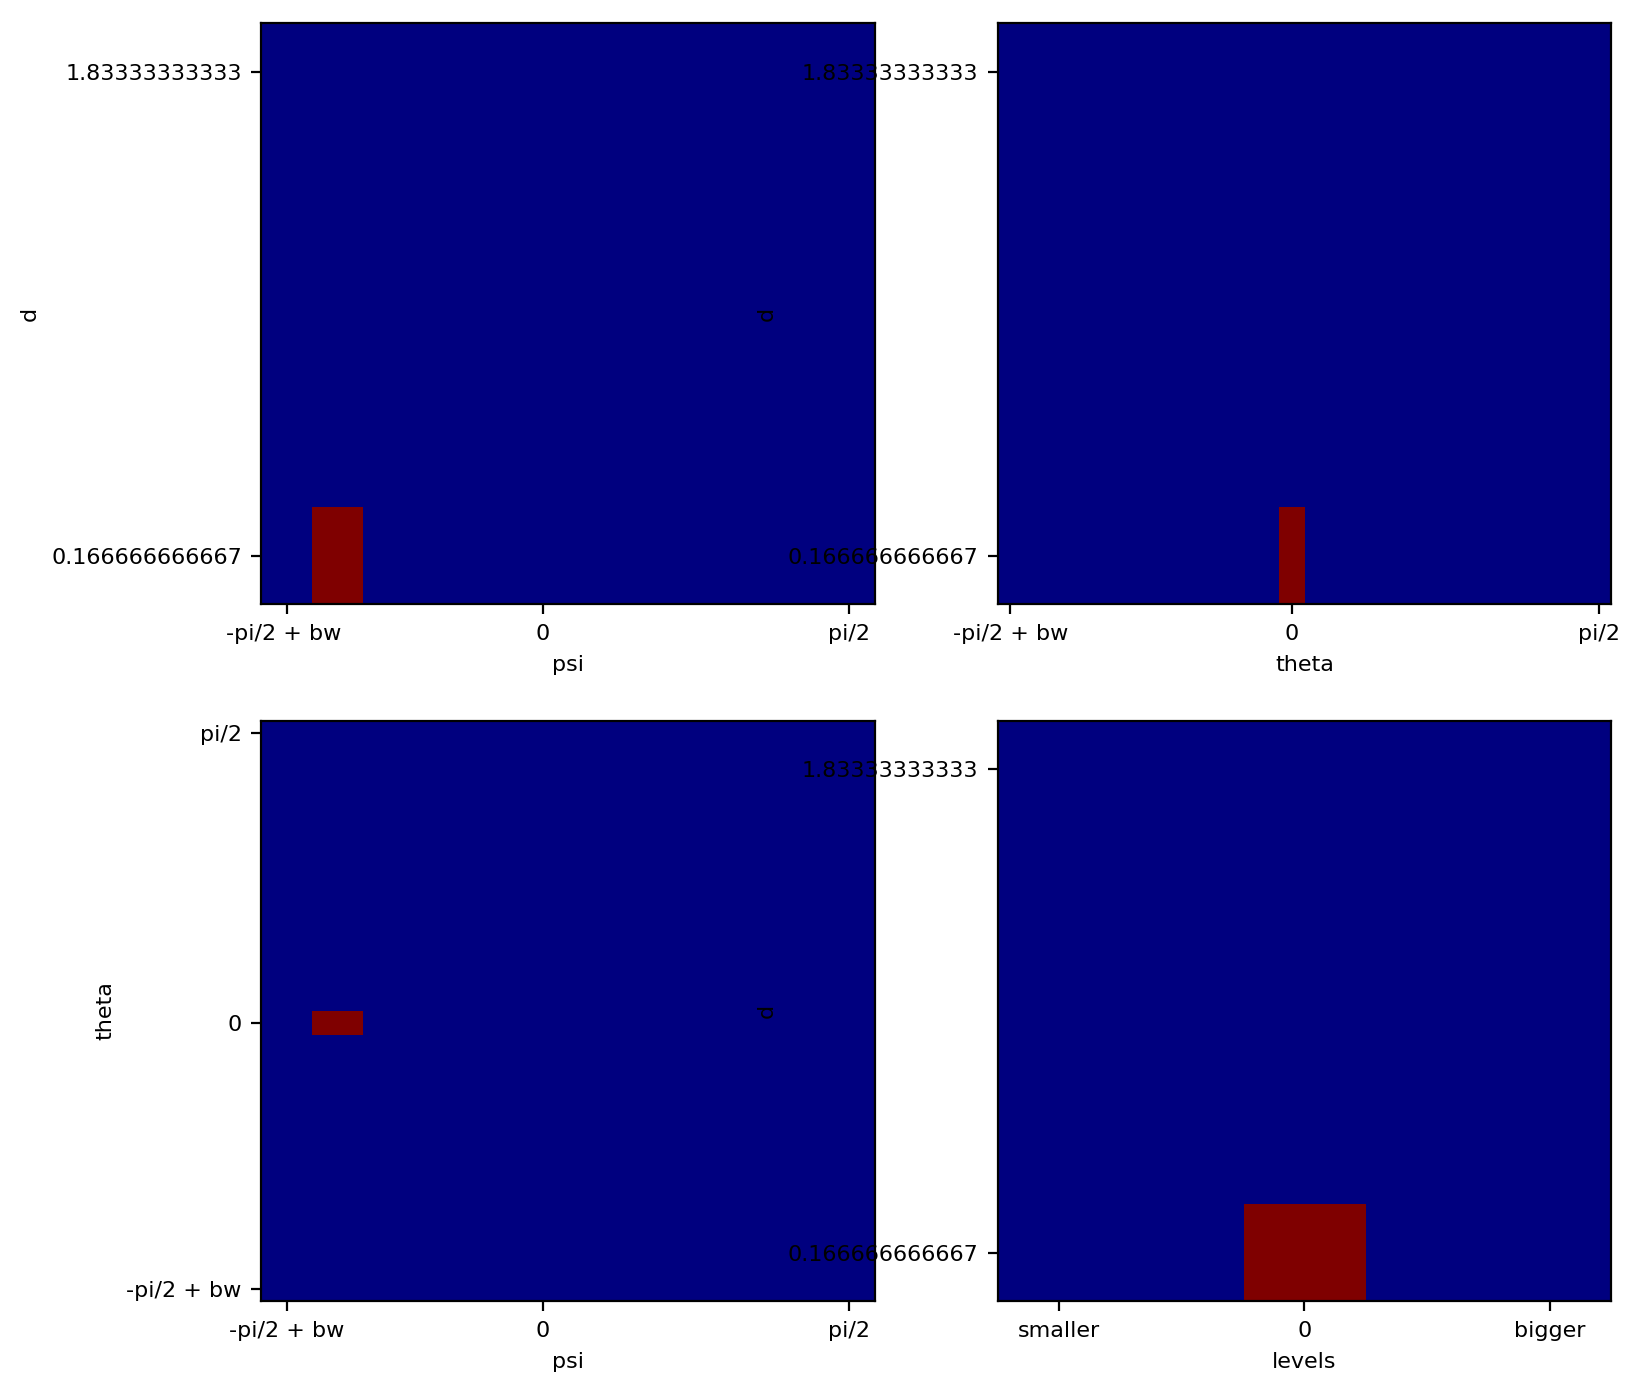

In [29]:
edgeslist = np.zeros((6, 2, mp.pe.N_image))
angle = np.pi/6
for i_N, sign in enumerate([-1., 1.]):
    edgeslist[0, i_N, :] = mp.pe.N_X *(1/2. + .1 * np.sin(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.pe.N_X *(1/2. + .1 * np.cos(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (angle + np.pi/360.* np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = .03
    edgeslist[4, i_N, :] = 1.
#print  edgeslist
_ = myplot(edgeslist, mp=mp)

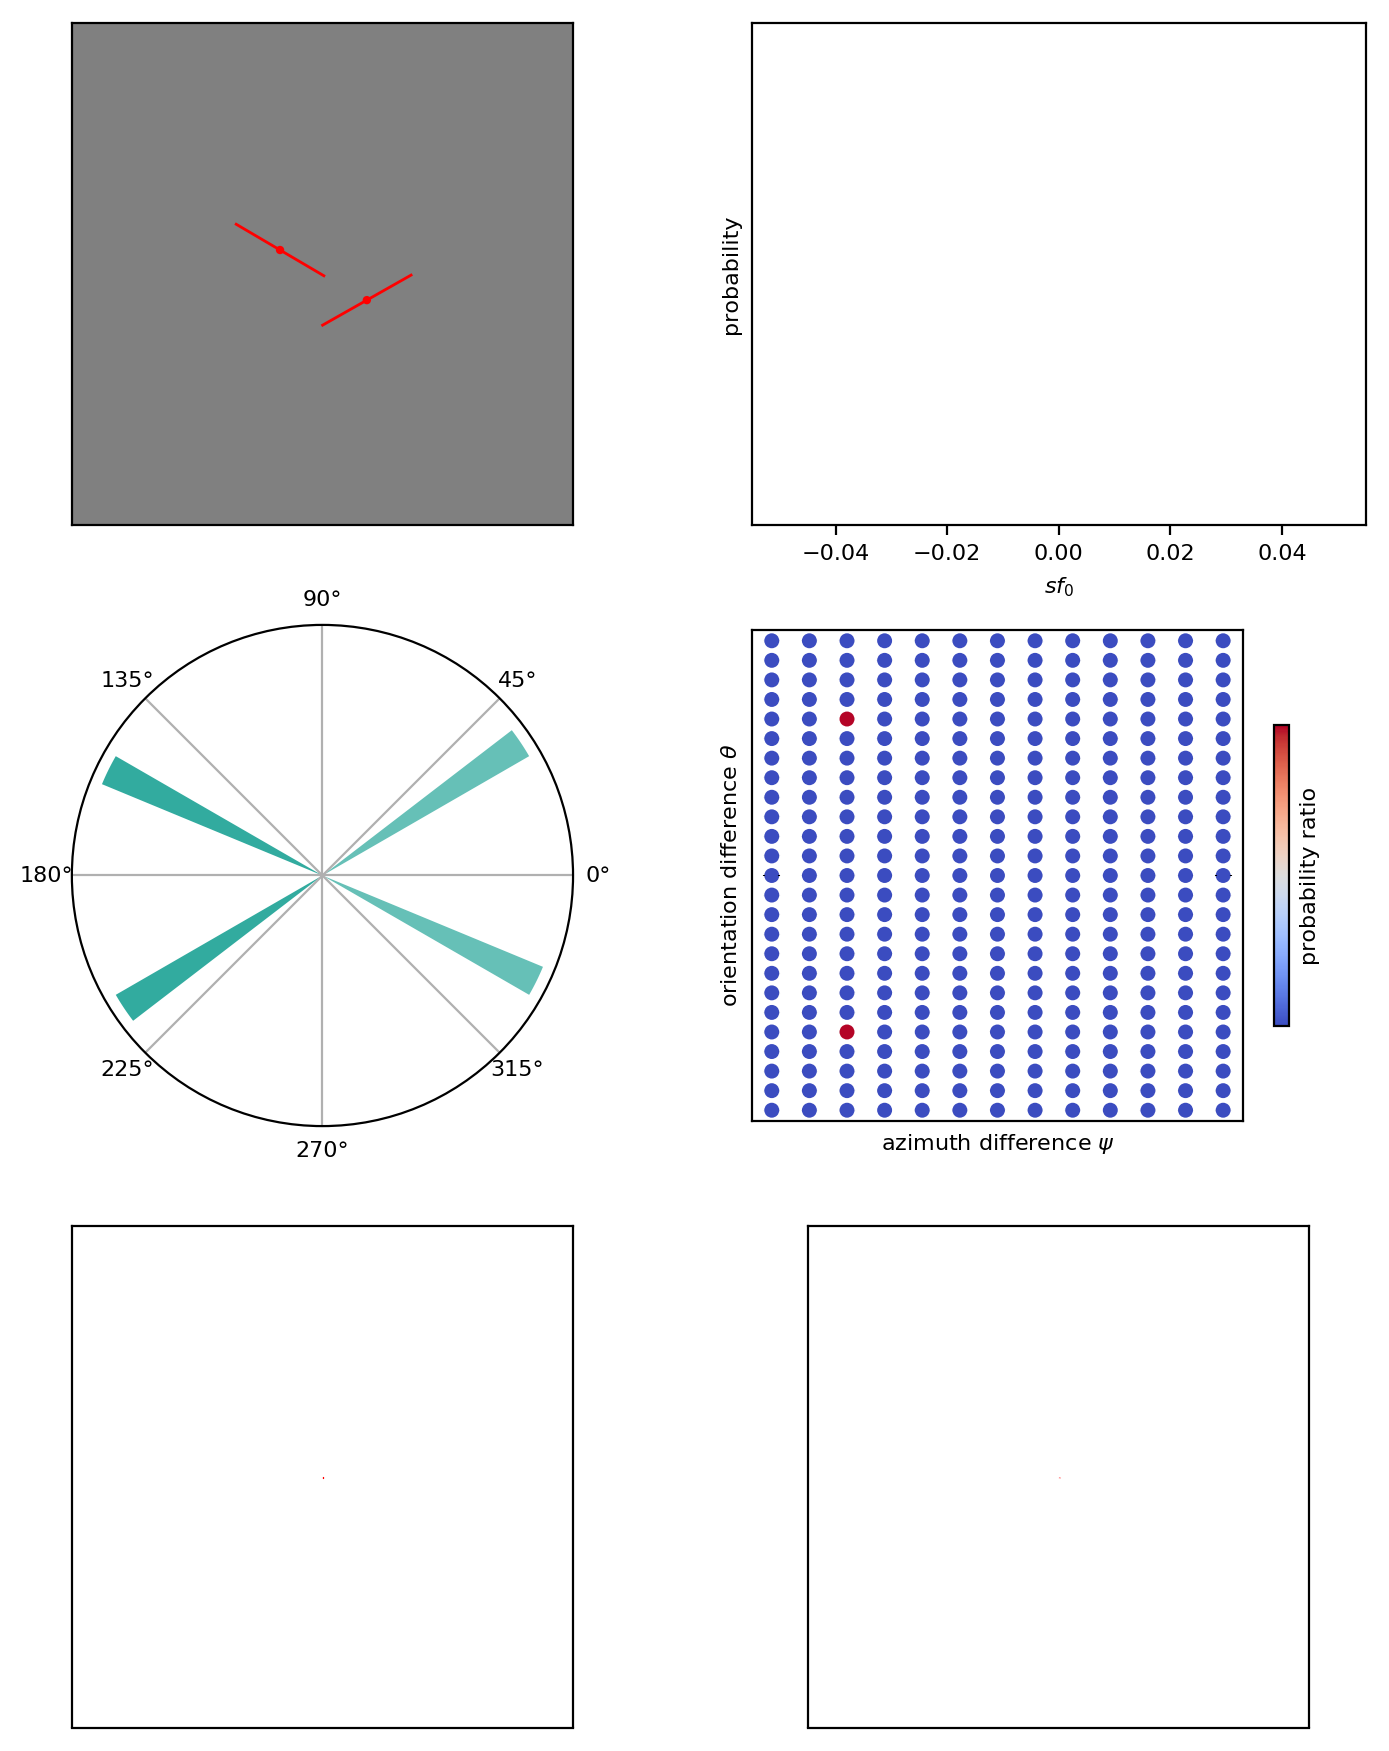

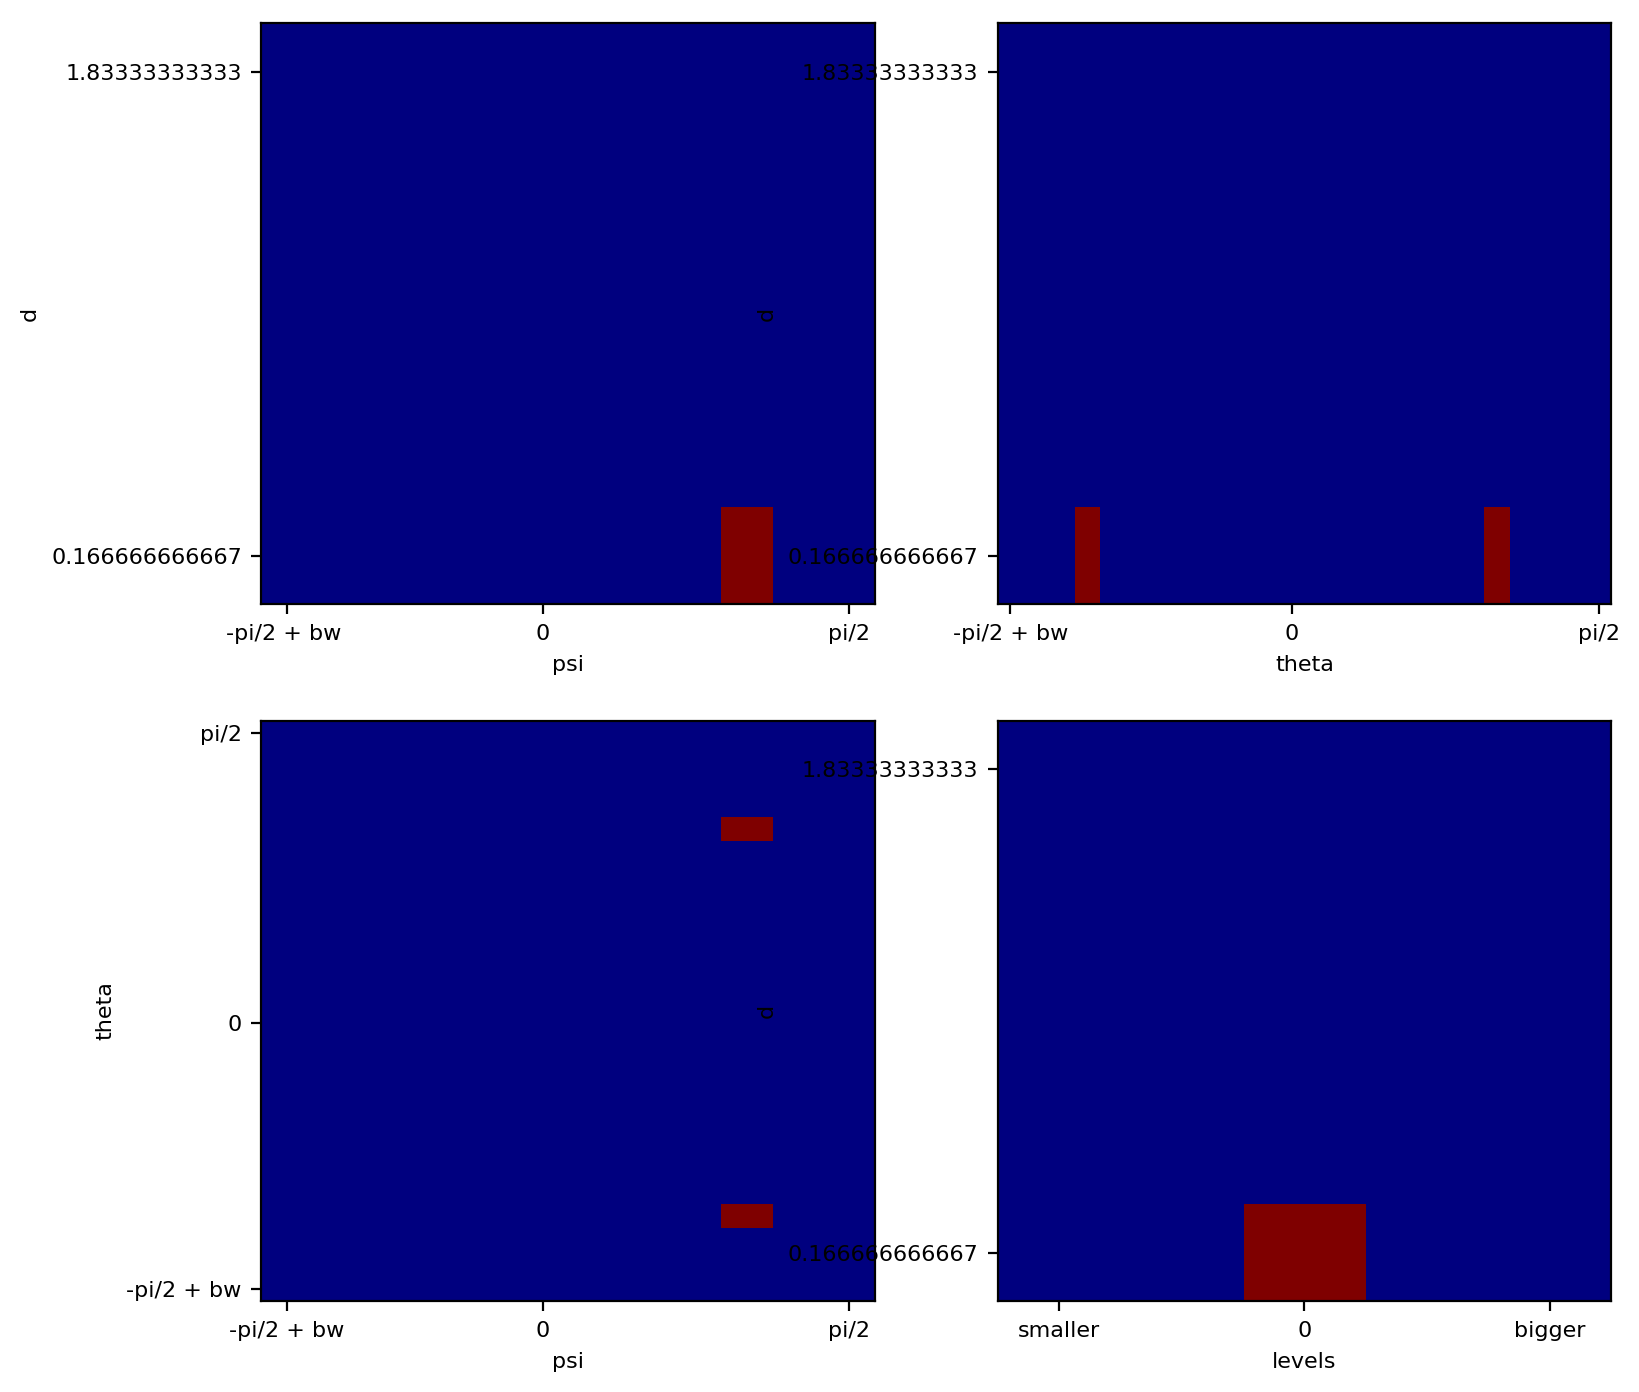

In [30]:
edgeslist = np.zeros((6, 2, mp.pe.N_image))
angle = np.pi/6
for i_N, sign in enumerate([-1., 1.]):
    edgeslist[0, i_N, :] = mp.pe.N_X *(1/2. + .1 * np.sin(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.pe.N_X *(1/2. + .1 * np.cos(angle) * sign) + .0005 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = sign*(angle + np.pi/360.* np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = .03
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)

#### random edges

1.618 11


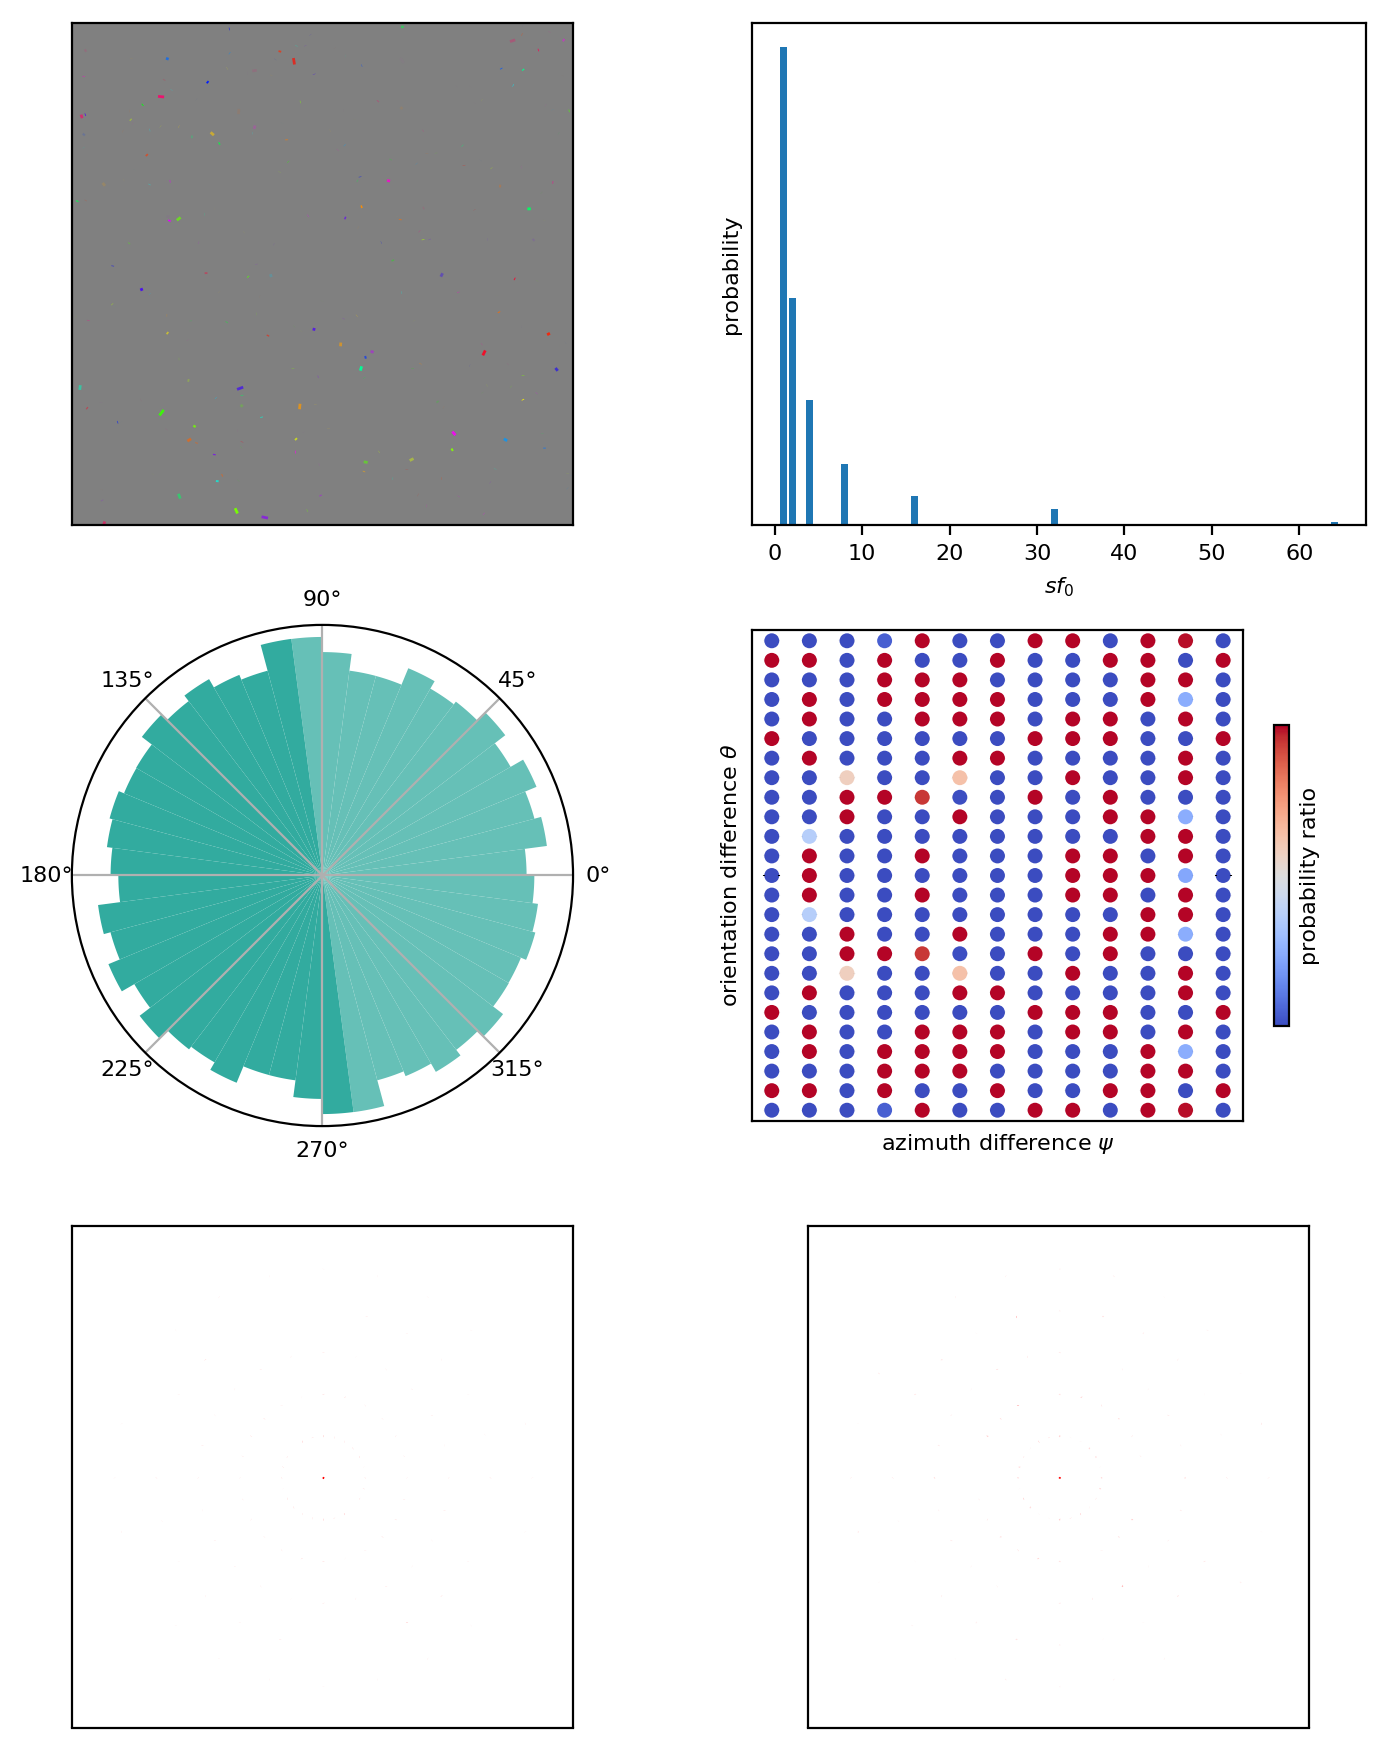

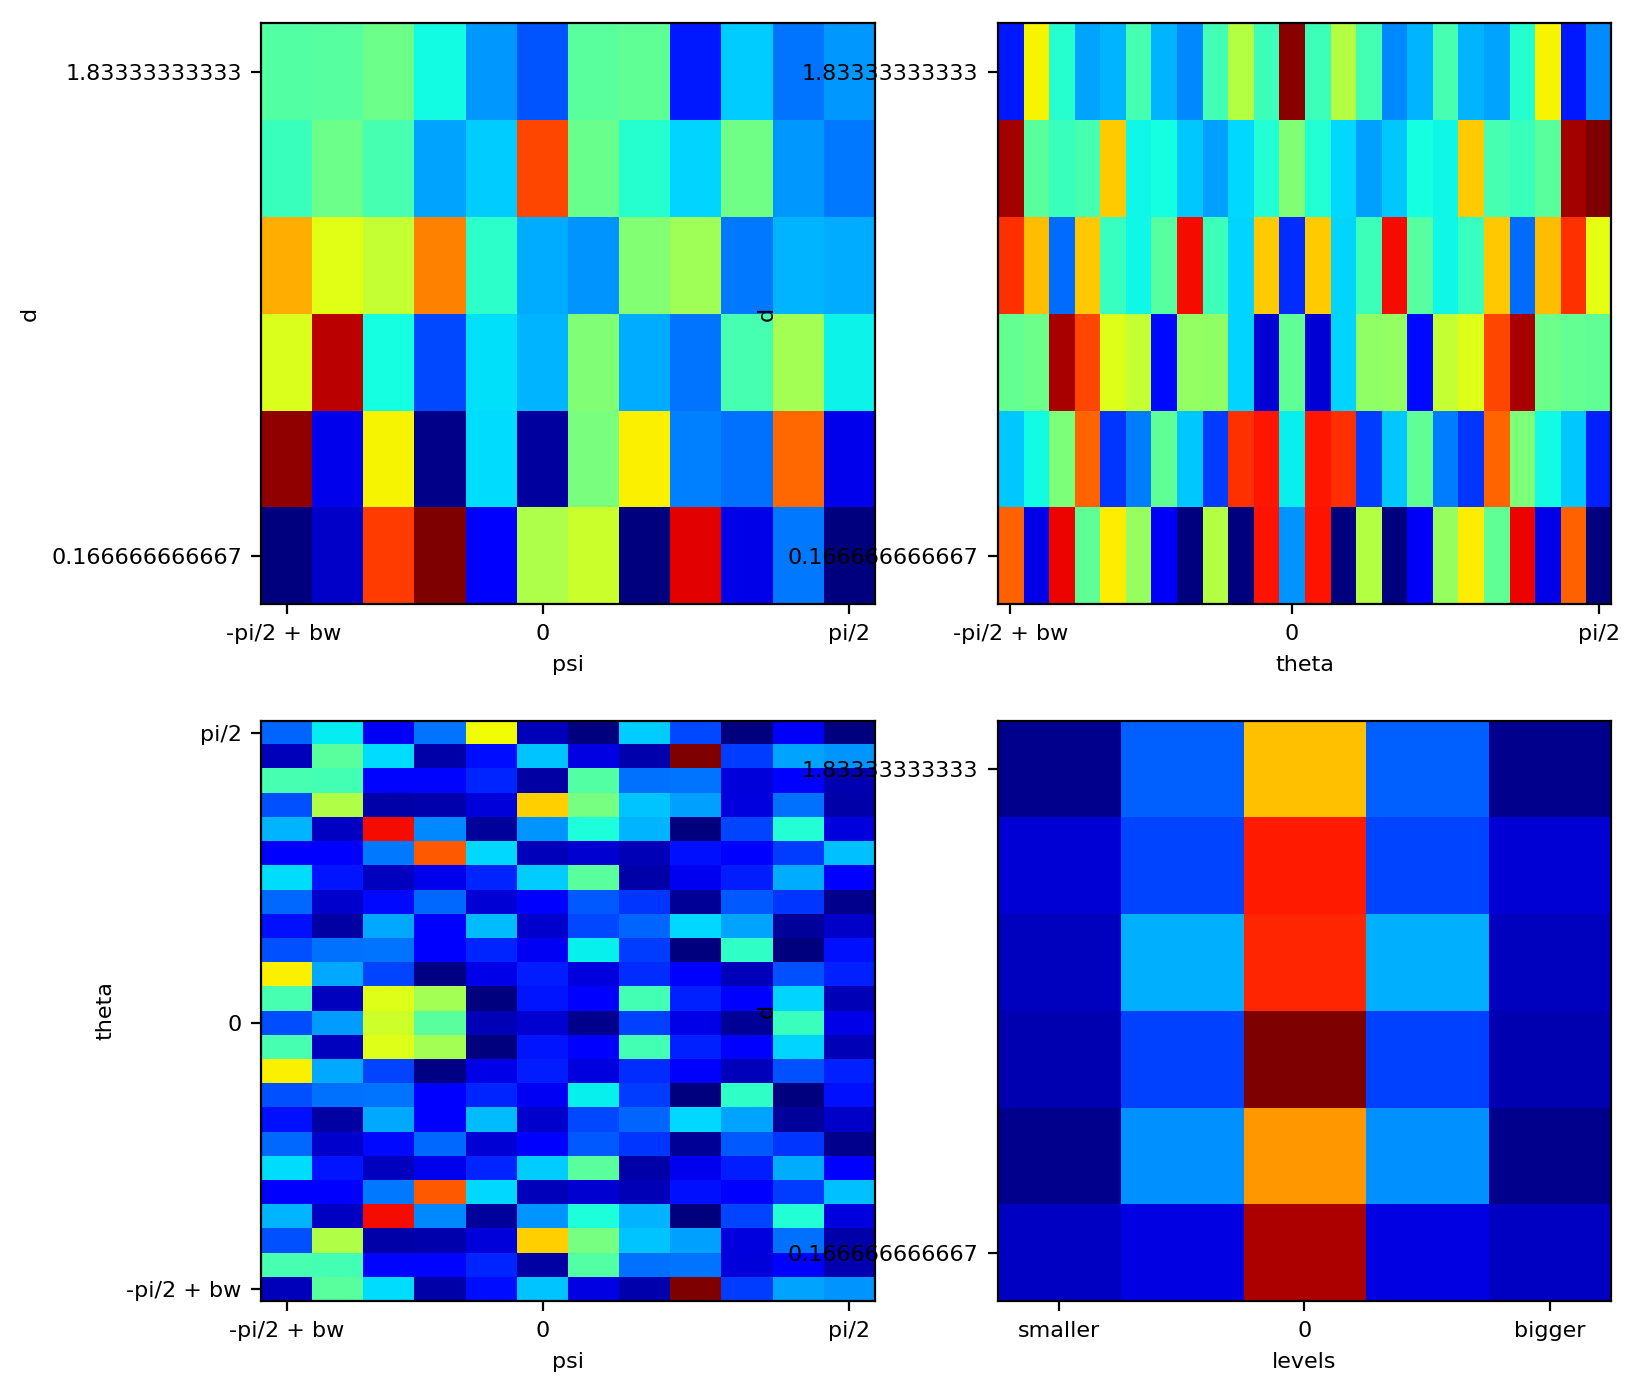

In [31]:
mp.pe.N = 256
print (mp.pe.base_levels, mp.n_levels)
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
edgeslist[0, :, :] = mp.pe.N_X * np.random.rand(mp.pe.N, mp.pe.N_image)
edgeslist[1, :, :] = mp.pe.N_X * np.random.rand(mp.pe.N, mp.pe.N_image)
edgeslist[2, :, :] = (np.pi* np.random.rand(mp.pe.N, mp.pe.N_image) ) % np.pi
edgeslist[3, :, :] =  .03*np.ceil(mp.pe.base_levels**(mp.n_levels*(np.random.rand(mp.pe.N, mp.pe.N_image)+.5)))
edgeslist[4, :, :] = np.random.rand(mp.pe.N, mp.pe.N_image) 
edgeslist[5, :, :] = 2*np.pi*np.random.rand(mp.pe.N, mp.pe.N_image)

_ = myplot(edgeslist, mp=mp)

#### parallel edges

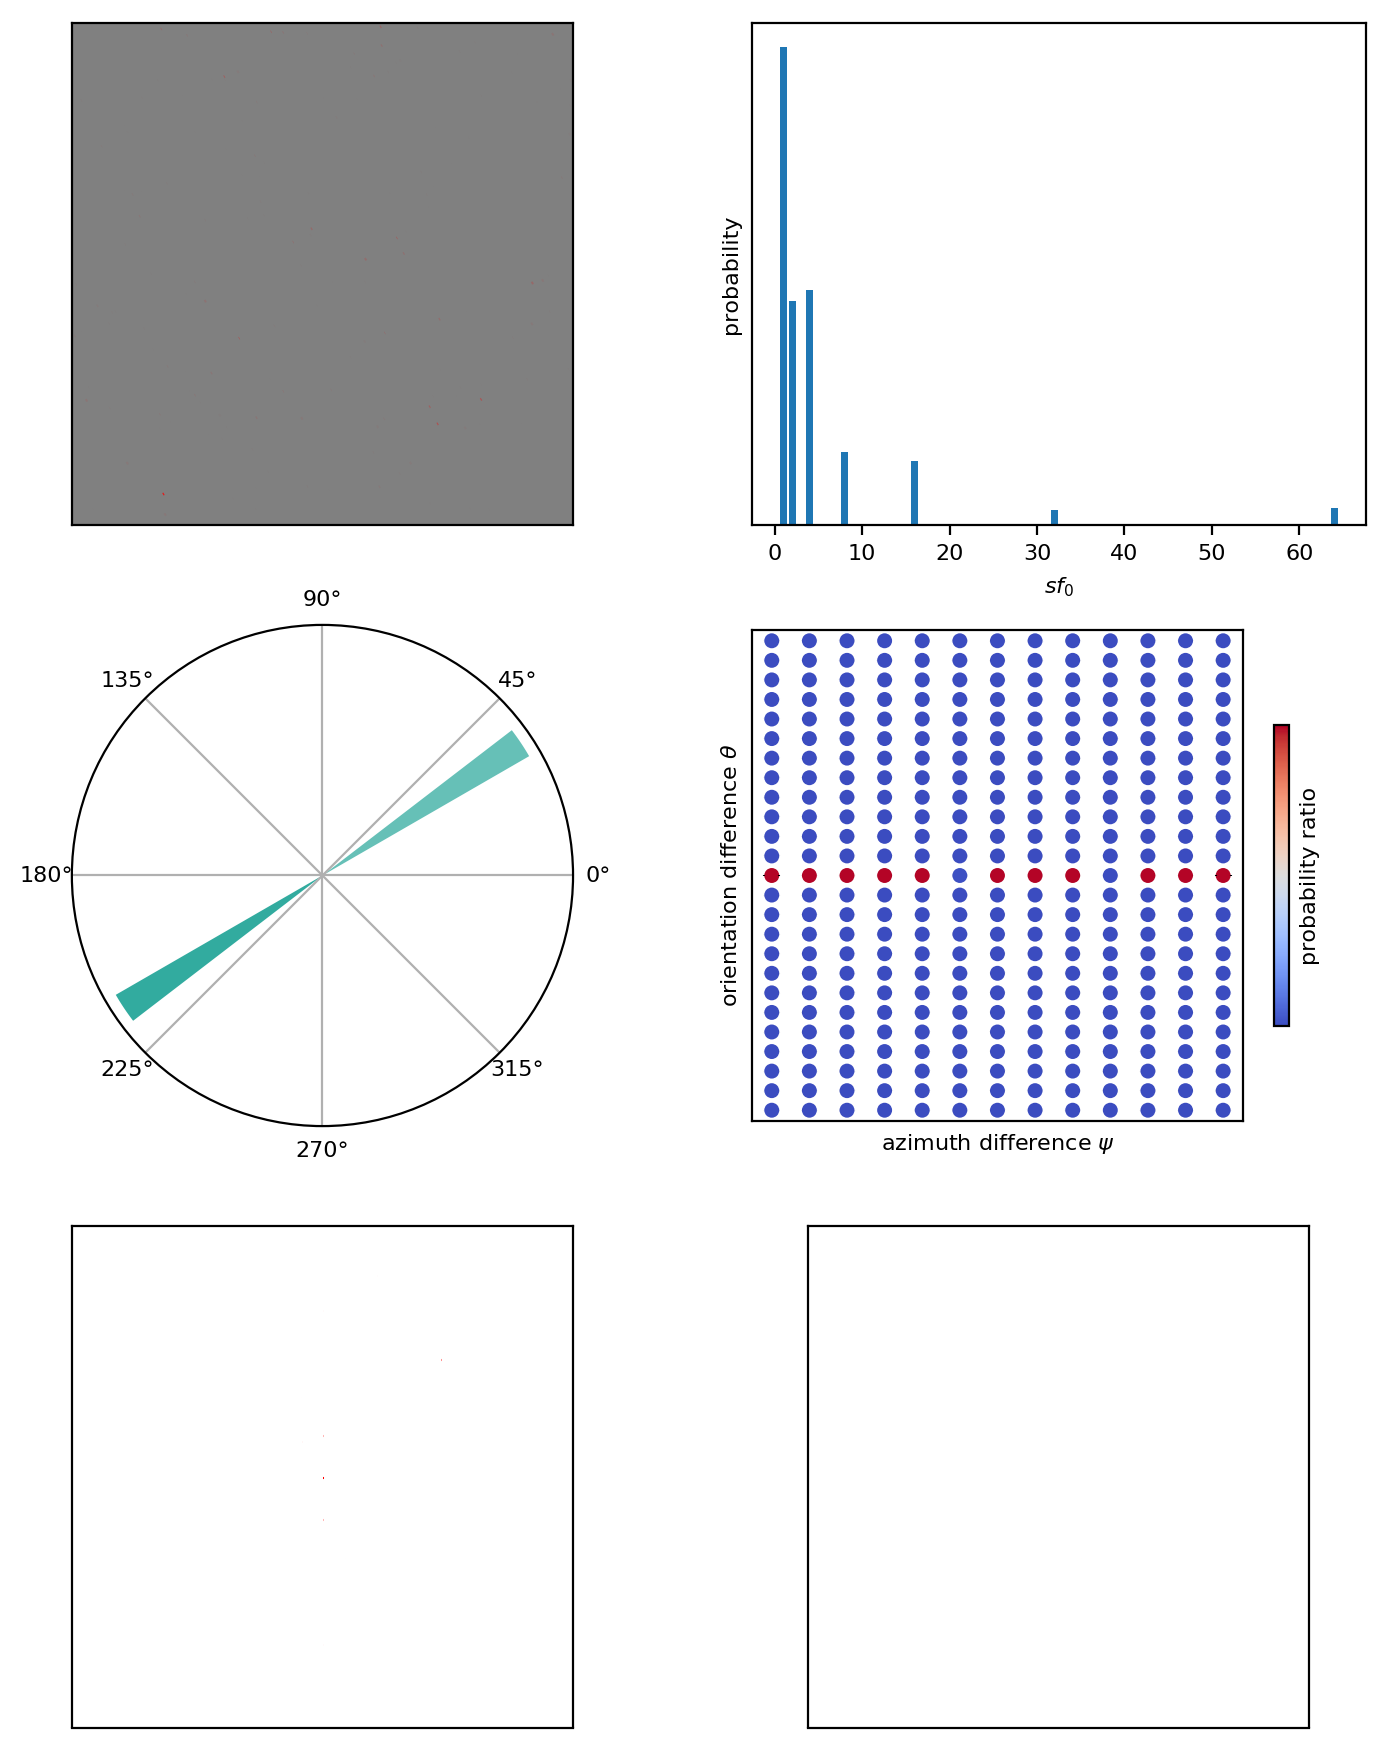

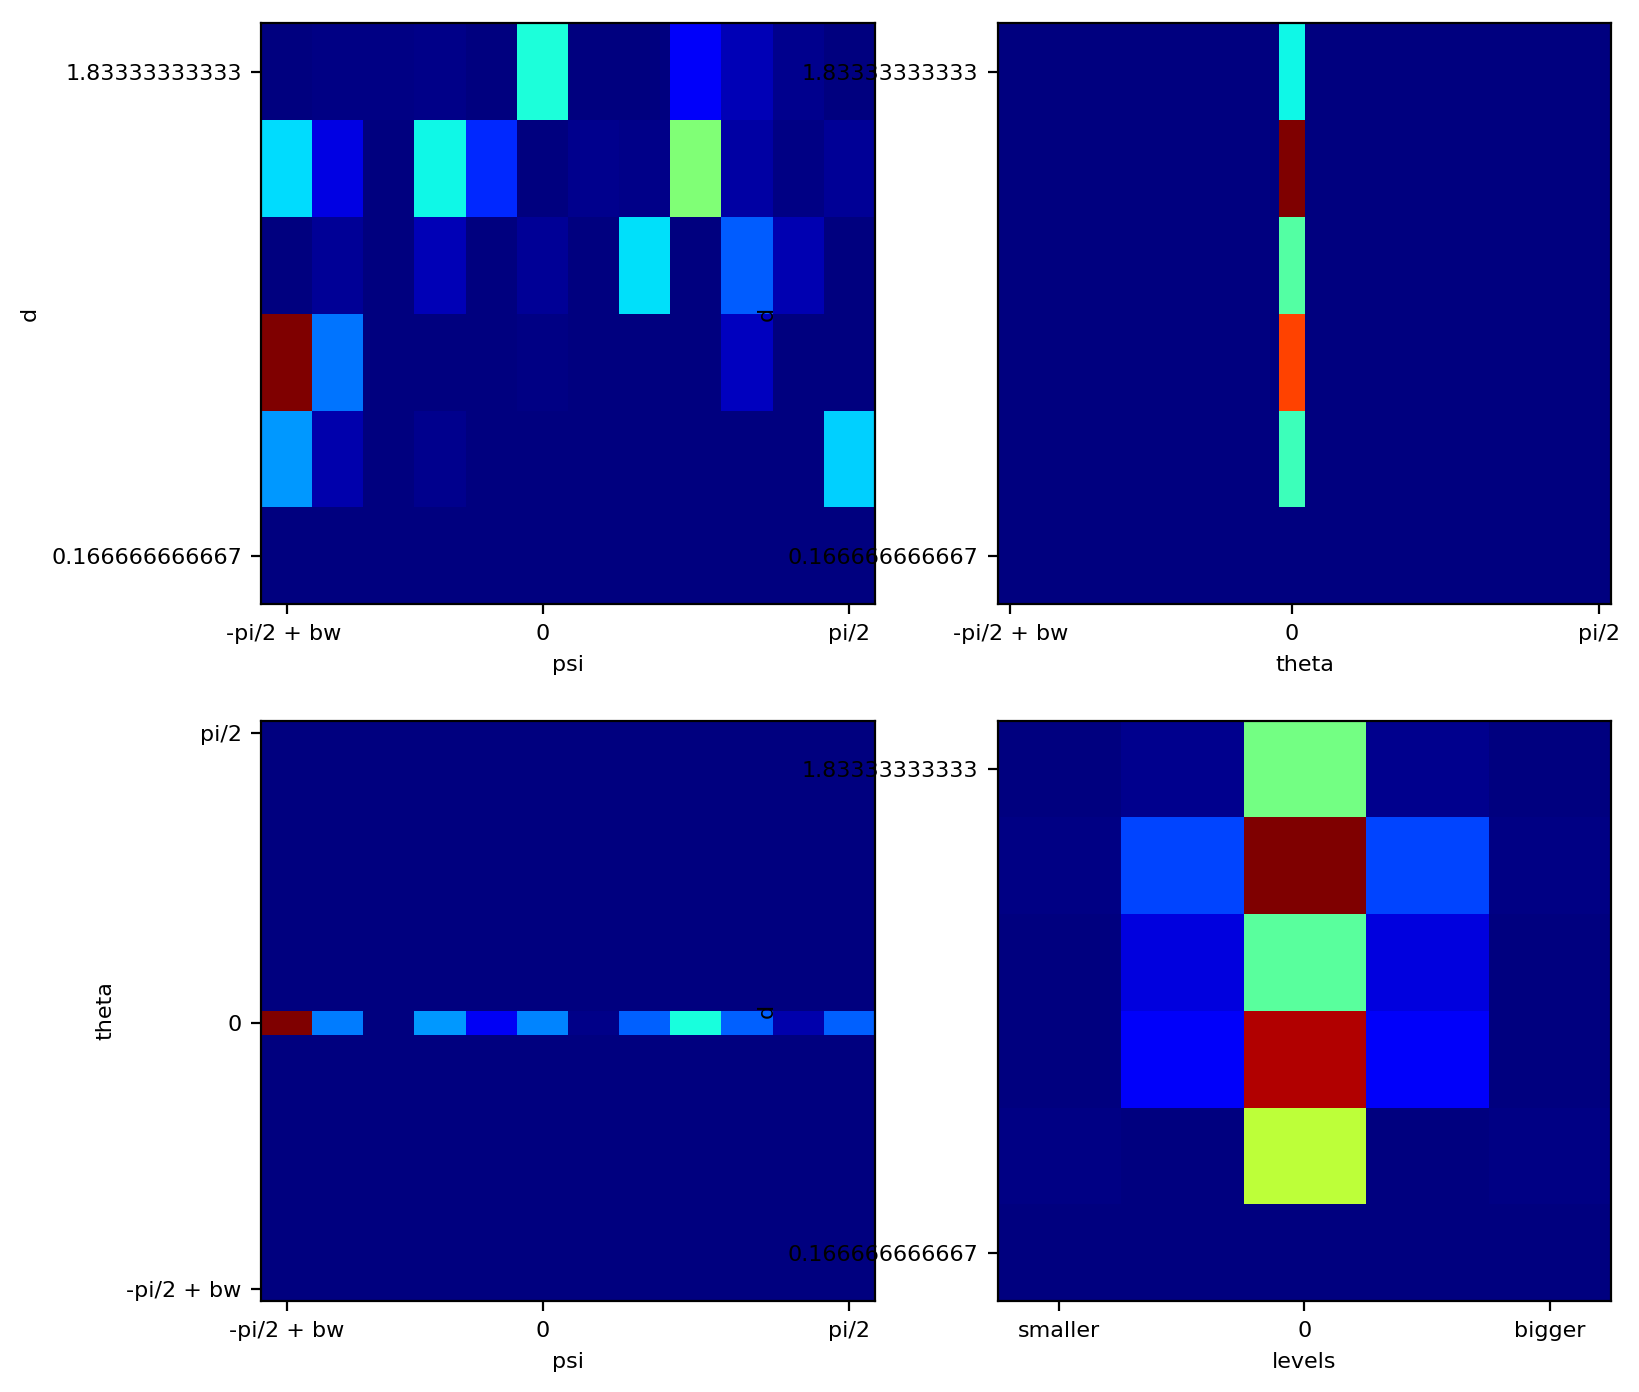

In [32]:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
for i_N, x in enumerate(np.linspace(-mp.pe.N_X/4., mp.pe.N_X/4., mp.pe.N)):
    edgeslist[0, i_N, :] = mp.pe.N_X * np.random.rand(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.pe.N_X * np.random.rand(mp.pe.N_image)
    edgeslist[2, i_N, :] = (np.pi/6 + np.pi/360.* np.random.randn(mp.pe.N_image) ) % np.pi
    edgeslist[3, i_N, :] = mp.pe.base_levels**np.ceil(mp.n_levels*np.random.rand(mp.pe.N_image))
    edgeslist[4, i_N, :] = np.random.randn(mp.pe.N_image)**2
#! show one sample
_ = myplot(edgeslist, mp=mp)

#print mp.cohistedges(edgeslist, display='none')

#### colinear edges

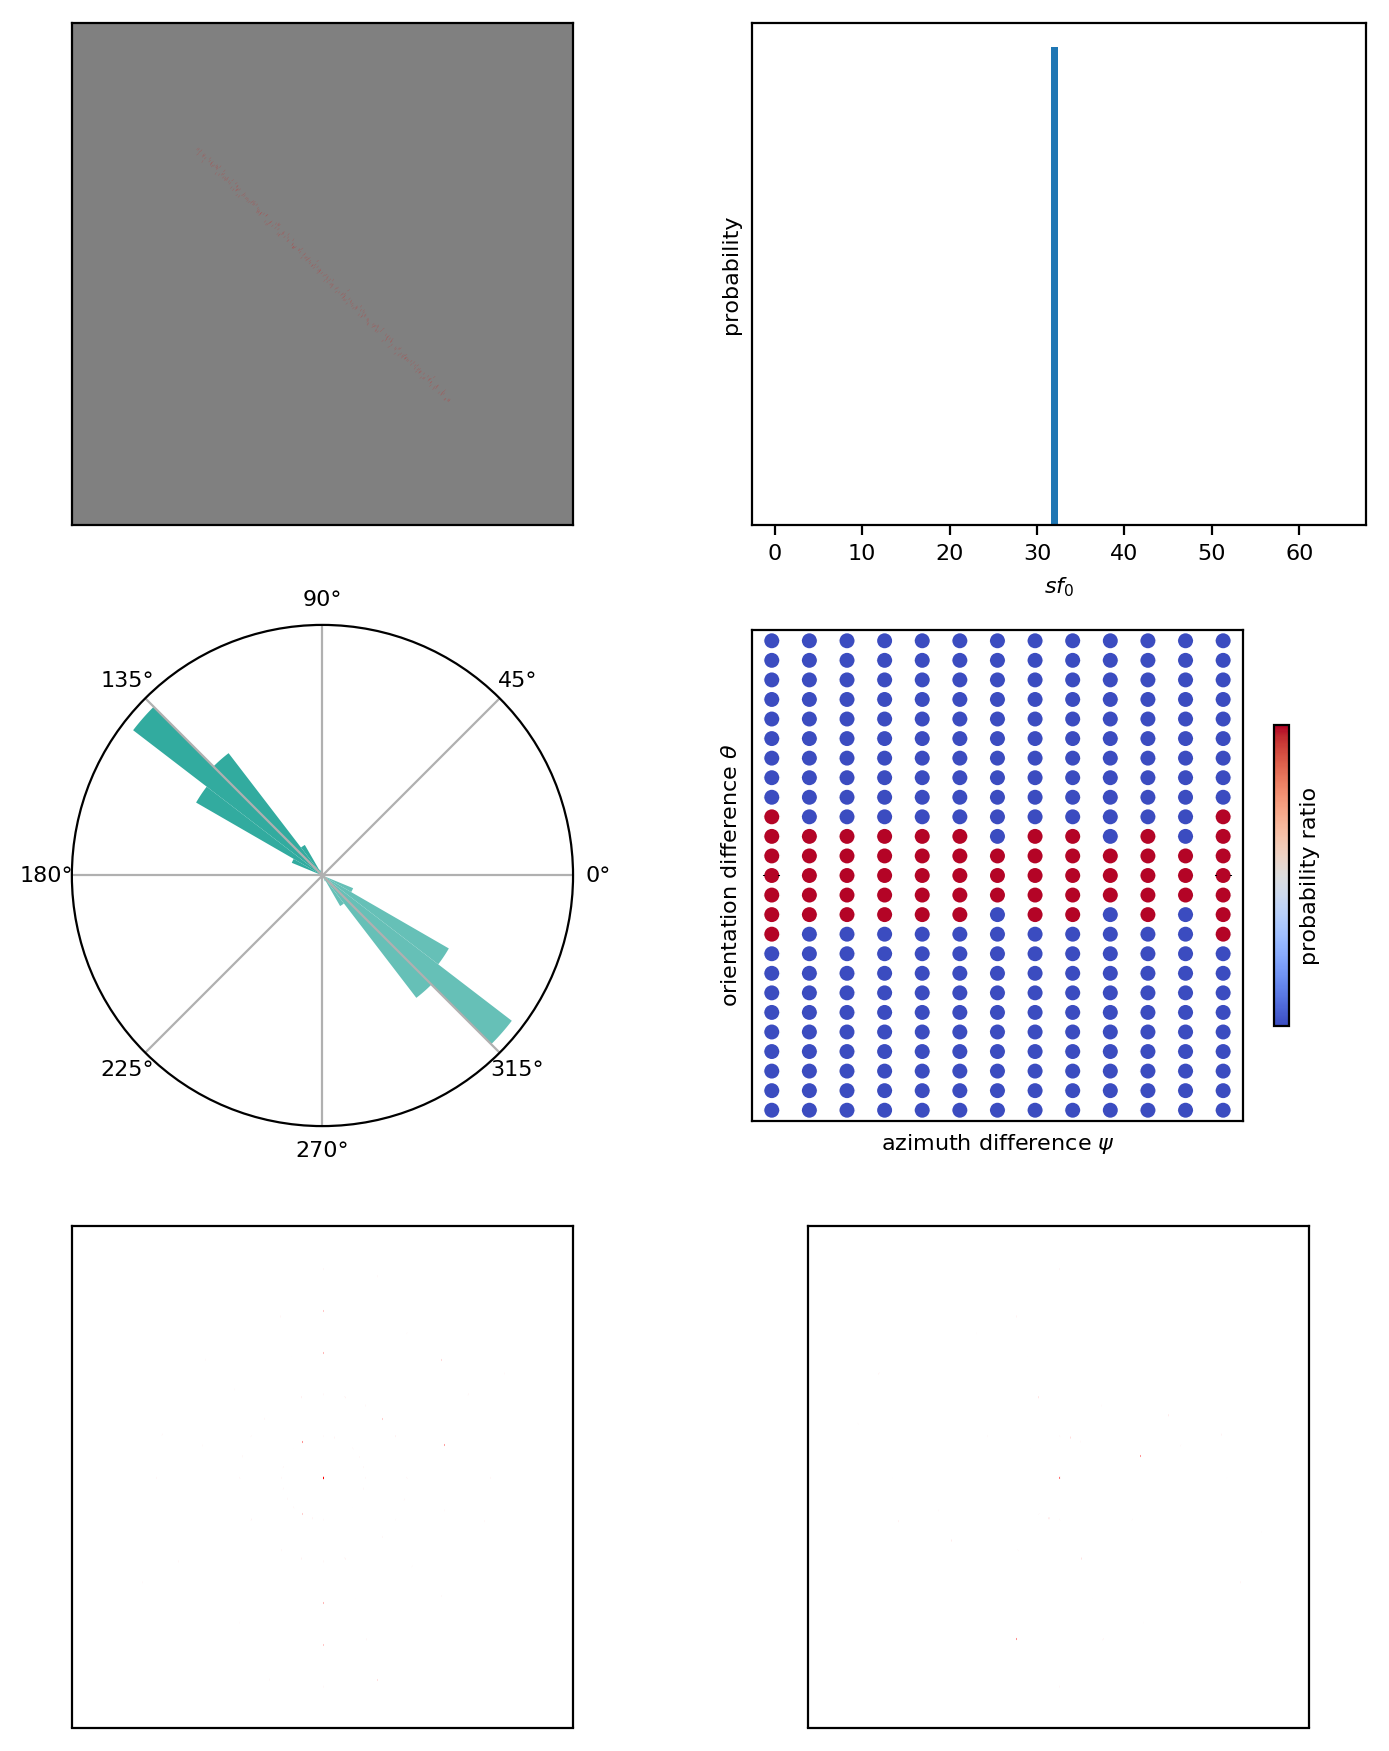

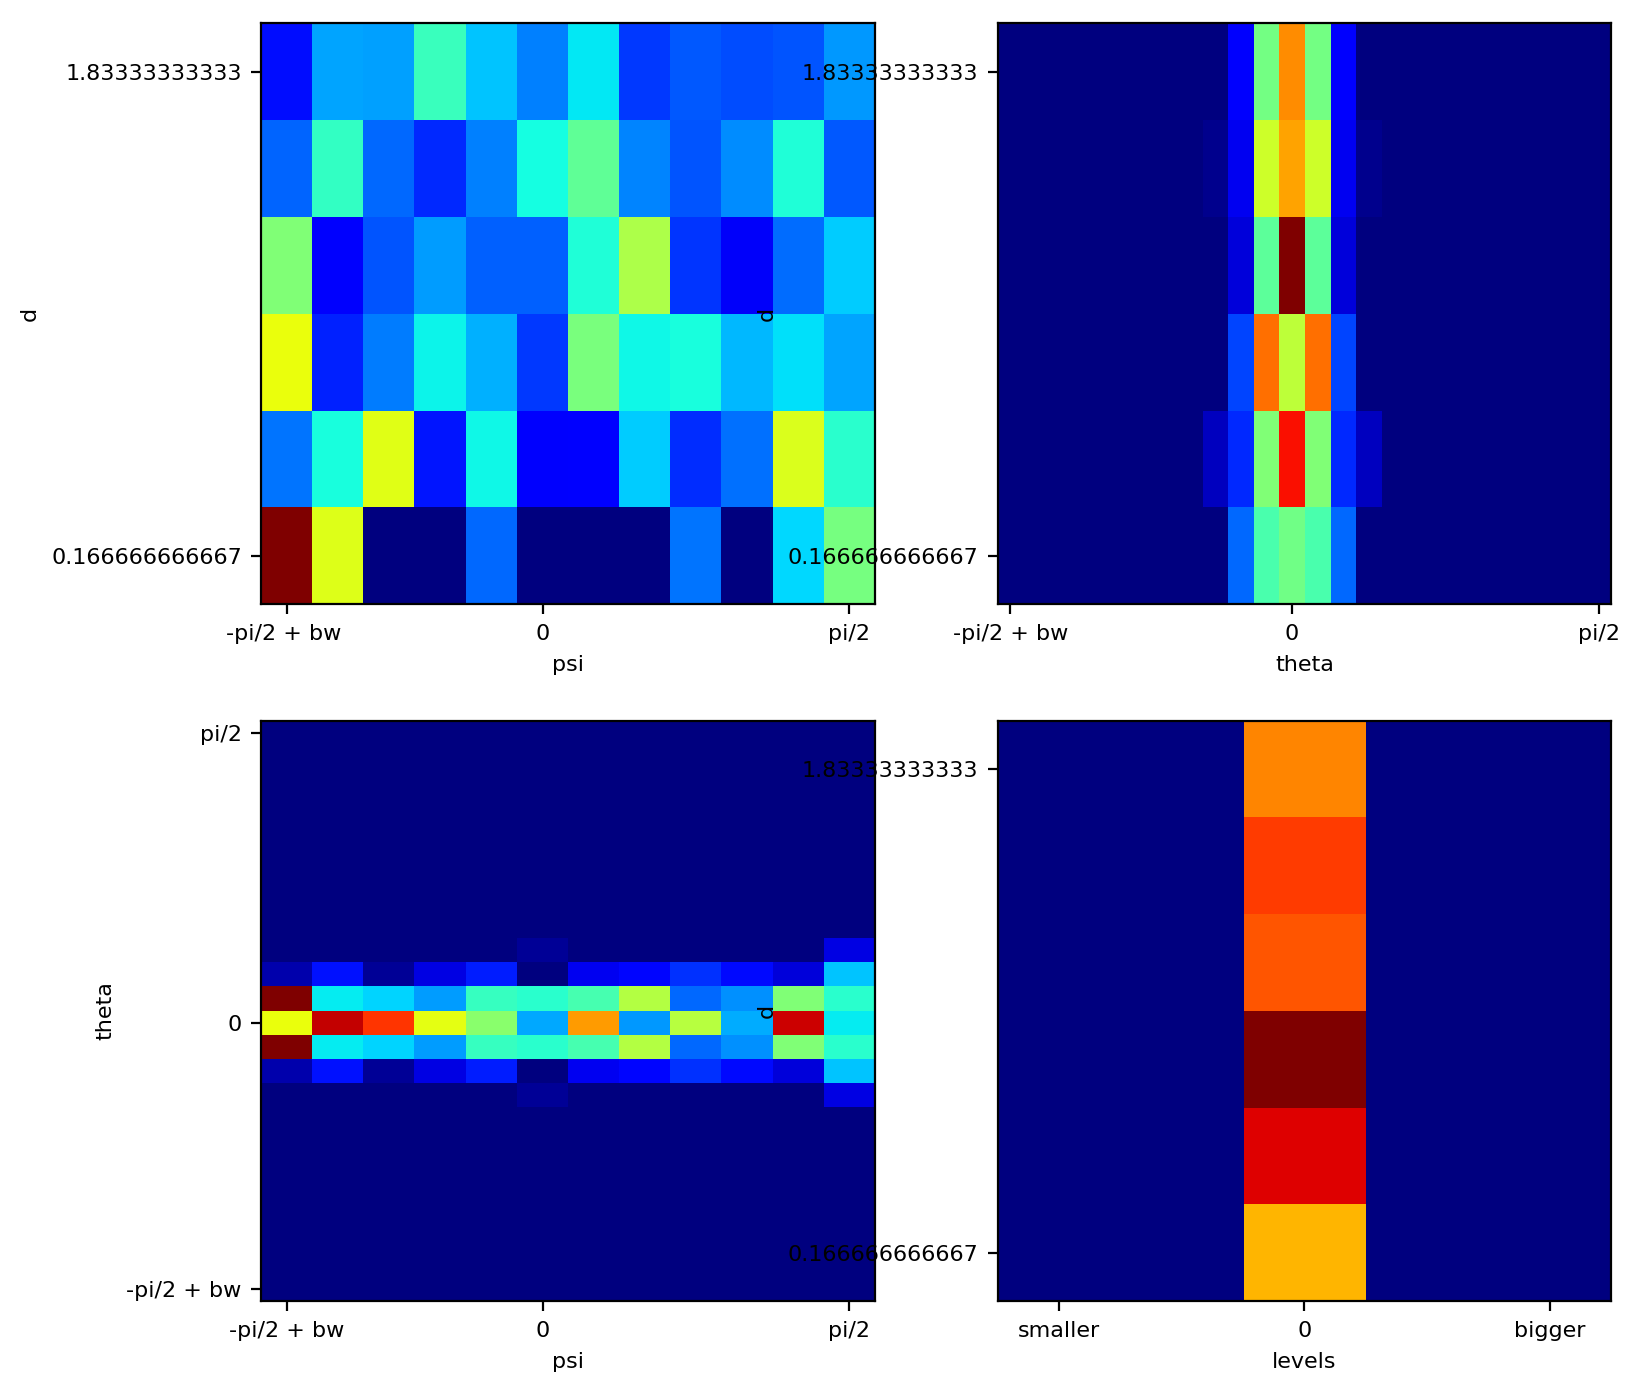

In [33]:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
for i_N, x in enumerate(np.linspace(-mp.pe.N_X/4., mp.pe.N_X/4., mp.pe.N)):
    edgeslist[0, i_N, :] = mp.pe.N_X/2. + x + 1. * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.pe.N_X/2. + x + 1. * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (-np.pi/4 + np.pi*5./180.* np.random.randn(mp.pe.N_image) ) % np.pi
    edgeslist[3, i_N, :] = 32. #np.sqrt(2.)/2 * N_X / N
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)#

In [34]:
def full_hist(edgeslist, **kwargs):
        v_hist = np.zeros((mp.pe.N_r, mp.pe.N_phi, mp.pe.N_Dtheta, mp.pe.N_scale, edgeslist.shape[2])) # bins=(self.edges_d, self.edges_phi, self.edges_theta, self.edges_loglevel)
        for i_image in range(edgeslist.shape[2]):
            v_hist[..., i_image] = mp.cohistedges(edgeslist[:, :, i_image][..., np.newaxis], display='none', **kwargs)
            v_hist[..., i_image] /= v_hist[..., i_image].sum()
        return v_hist

In [35]:
#! using first database
#print im.get_imagelist(exp='testing_vanilla', name_database='serre07_distractors')
#!ls mat/edges/testing_vanilla_serre07_distractors/

#### plotting with distractors

In [36]:
#edgeslist = np.load('../AssoField/mat/classifier_serre07_distractors_edges.npy')
mp.pe.datapath = '../../SLIP/database/'
imageslist, edgeslist, RMSE = mp.process(exp='Sparselets', name_database='serre07_distractors')

In [37]:
#_ = myplot(edgeslist[:, :, 0][:, :, np.newaxis], pe=pe)

In [38]:
import os
matname = os.path.join(mp.pe.matpath, 'Sparselets_serre07_distractors_hist.npy')
try:
    v_hist = np.load(matname)
except Exception as e:
    import os
    if not(os.path.isfile(matname + '_lock')):
        print( 'There is no histogram, creating one: ', e)
        open(matname + '_lock', 'w').close() # touching
        v_hist = myplot(edgeslist, mp=mp)
        np.save(matname, v_hist)
        os.remove(matname + '_lock')
    else:
        print (' Some process is building the histogram ' + matname   ) 

#### the same with more noise

In [39]:
imageslist, edgeslist, RMSE = mp.process(exp='testing_noise', name_database='serre07_distractors')

matname = os.path.join(mp.pe.matpath, 'testing_noise_vanilla_serre07_distractors_hist.npy')
try:
    v_hist = np.load(matname)
except Exception as e:
    if not(os.path.isfile(matname + '_lock')):
        print ('There is no histogram, creating one: ', e)
        open(matname + '_lock', 'w').close() # touching
        v_hist = myplot(edgeslist, mp=mp)
        np.save(matname, v_hist)
        os.remove(matname + '_lock')
    else:
        print (' Some process is building the histogram ' + matname)

       
#edgeslist = np.load('../AssoField/mat/classifier_noise_serre07_targets_edges.npy')
#! show one sample
#fig, a = mp.show_edges(edgeslist[:, :, 0], image=None)
#v = pylab.axis((0, pe.N_X, pe.N_X, 0))

#### plotting with targets

using second database

In [40]:
#! using second database
#!----------------------
imageslist, edgeslist, RMSE = mp.process(exp='testing_vanilla', name_database='serre07_targets')
#edgeslist = np.load('mat/testing_vanilla_serre07_targets_edges.npy')
#_ = myplot(edgeslist[:, :, 0][:, :, np.newaxis], pe=pe)

In [41]:
#!rm mat/testing_vanilla_serre07_targets_hist.npy*
matname = os.path.join(mp.pe.matpath, 'testing_vanilla_serre07_targets_hist.npy')
try:
    v_hist = np.load(matname)
except Exception as e:
    if not(os.path.isfile(matname + '_lock')):
        print ('There is no histogram, creating one: ', e)
        open(matname + '_lock', 'w').close() # touching
        v_hist = myplot(edgeslist, mp=mp)
        np.save(matname, v_hist)
        os.remove(matname + '_lock')
    else:
        print (' Some process is building the histogram ' + matname)


In [42]:
#v_hist = mp.cohistedges(edgeslist, display='none')

Note that the histogram is symmetric with respect to log-scales

In [43]:
mp.init_edges()
print (mp.edges_d.max())
print (v_hist.shape)
print (mp.edges_loglevel)

2.0
(6, 12, 24, 5)
[-7.  -4.2 -1.4  1.4  4.2  7. ]


In [44]:
l_ = v_hist.sum(axis=(2, 1, 0))
print (l_, l_-l_[::-1])

[  6.8527e-04   4.2224e-02   9.1418e-01   4.2224e-02   6.8527e-04] [  1.6263e-18  -9.0206e-17   0.0000e+00   9.0206e-17  -1.6263e-18]


In [45]:
print (np.sum(v_hist), np.sum((v_hist - v_hist[:, :, :, ::-1])**2))

1.0 1.57907744347e-05


In [46]:
v_hist[:, 4, 4, 1]*100, v_hist[:, 4, 4, 3]*100

(array([  4.6364e-05,   3.7905e-05,   2.5641e-05,   1.8129e-05,
          1.2665e-05,   8.5024e-06]),
 array([  4.5910e-05,   3.6437e-05,   2.6662e-05,   1.8364e-05,
          1.3514e-05,   8.8097e-06]))

In [47]:
np.set_printoptions(precision=5, suppress=True)
v_hist_chevrons = v_hist.sum(axis=(0,3))
print (v_hist_chevrons.shape)

(12, 24)


In [48]:
print (v_hist_chevrons)
print (v_hist_chevrons[:, 6:11])
print (v_hist_chevrons[:, :6:-1])


[[ 0.00646  0.00518  0.0058   0.00552  0.00784  0.00714  0.00575  0.00911
   0.00585  0.0034   0.00262  0.00462  0.00262  0.0034   0.00585  0.00639
   0.00575  0.00714  0.00784  0.00552  0.0058   0.00518  0.00646  0.00679]
 [ 0.00462  0.00562  0.00476  0.00424  0.00244  0.00359  0.00255  0.00579
   0.00407  0.00246  0.00133  0.00671  0.00133  0.00246  0.00407  0.00579
   0.00255  0.00359  0.00244  0.00423  0.00476  0.00562  0.00462  0.00525]
 [ 0.00107  0.00235  0.00282  0.0024   0.00372  0.00343  0.00351  0.00392
   0.00597  0.00191  0.00271  0.0051   0.00271  0.00191  0.00597  0.00392
   0.00351  0.00343  0.00372  0.0024   0.00282  0.00235  0.00107  0.00176]
 [ 0.00002  0.00002  0.00002  0.00155  0.00143  0.00261  0.00368  0.0058
   0.00473  0.00214  0.00245  0.00369  0.00245  0.00214  0.00473  0.0058
   0.00368  0.00261  0.00143  0.00155  0.00002  0.00002  0.00002  0.00002]
 [ 0.00002  0.00002  0.00002  0.00002  0.00002  0.00002  0.00002  0.00244
   0.00295  0.00248  0.0029   0.0047

#### cocircular edges

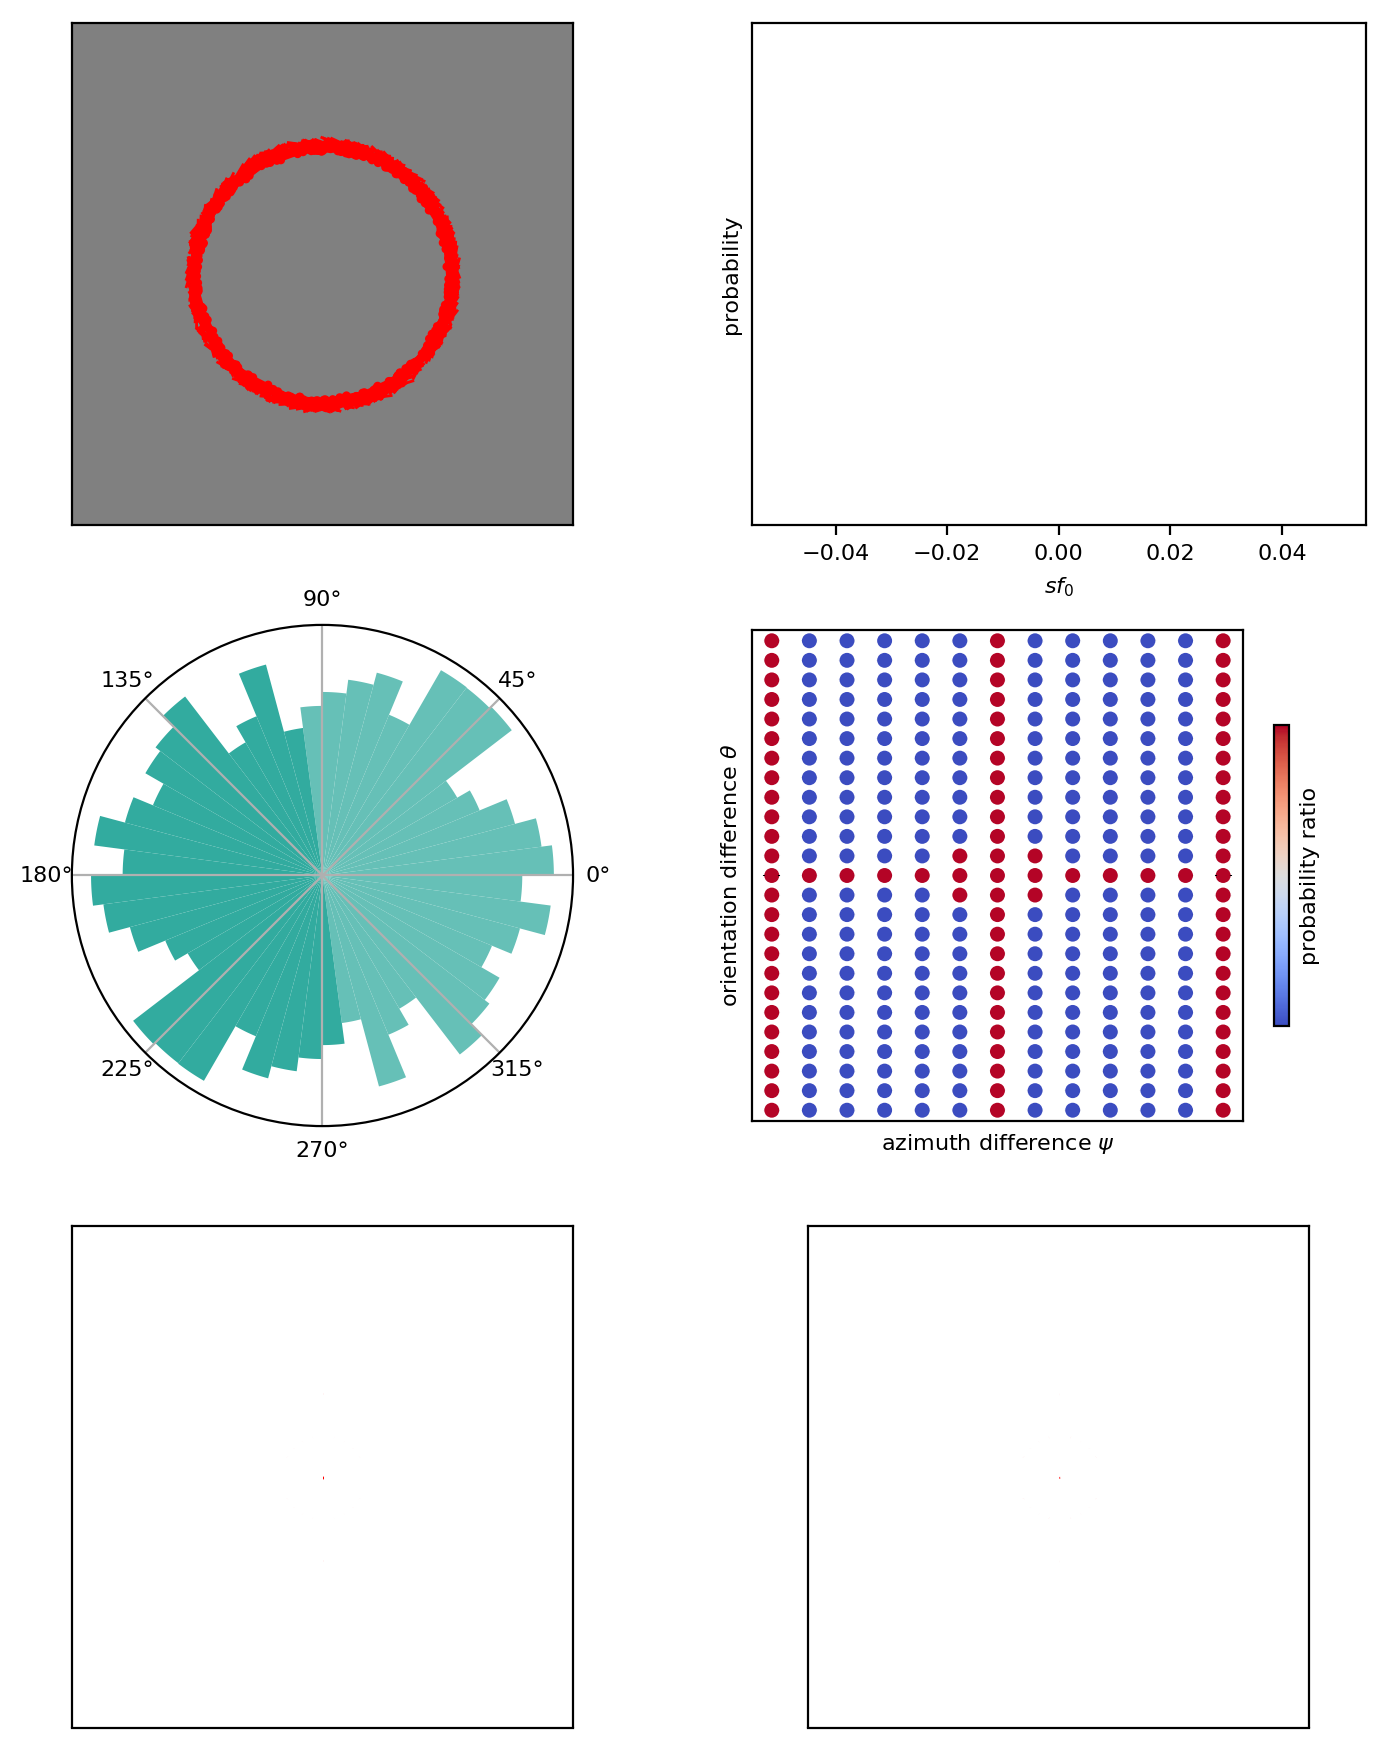

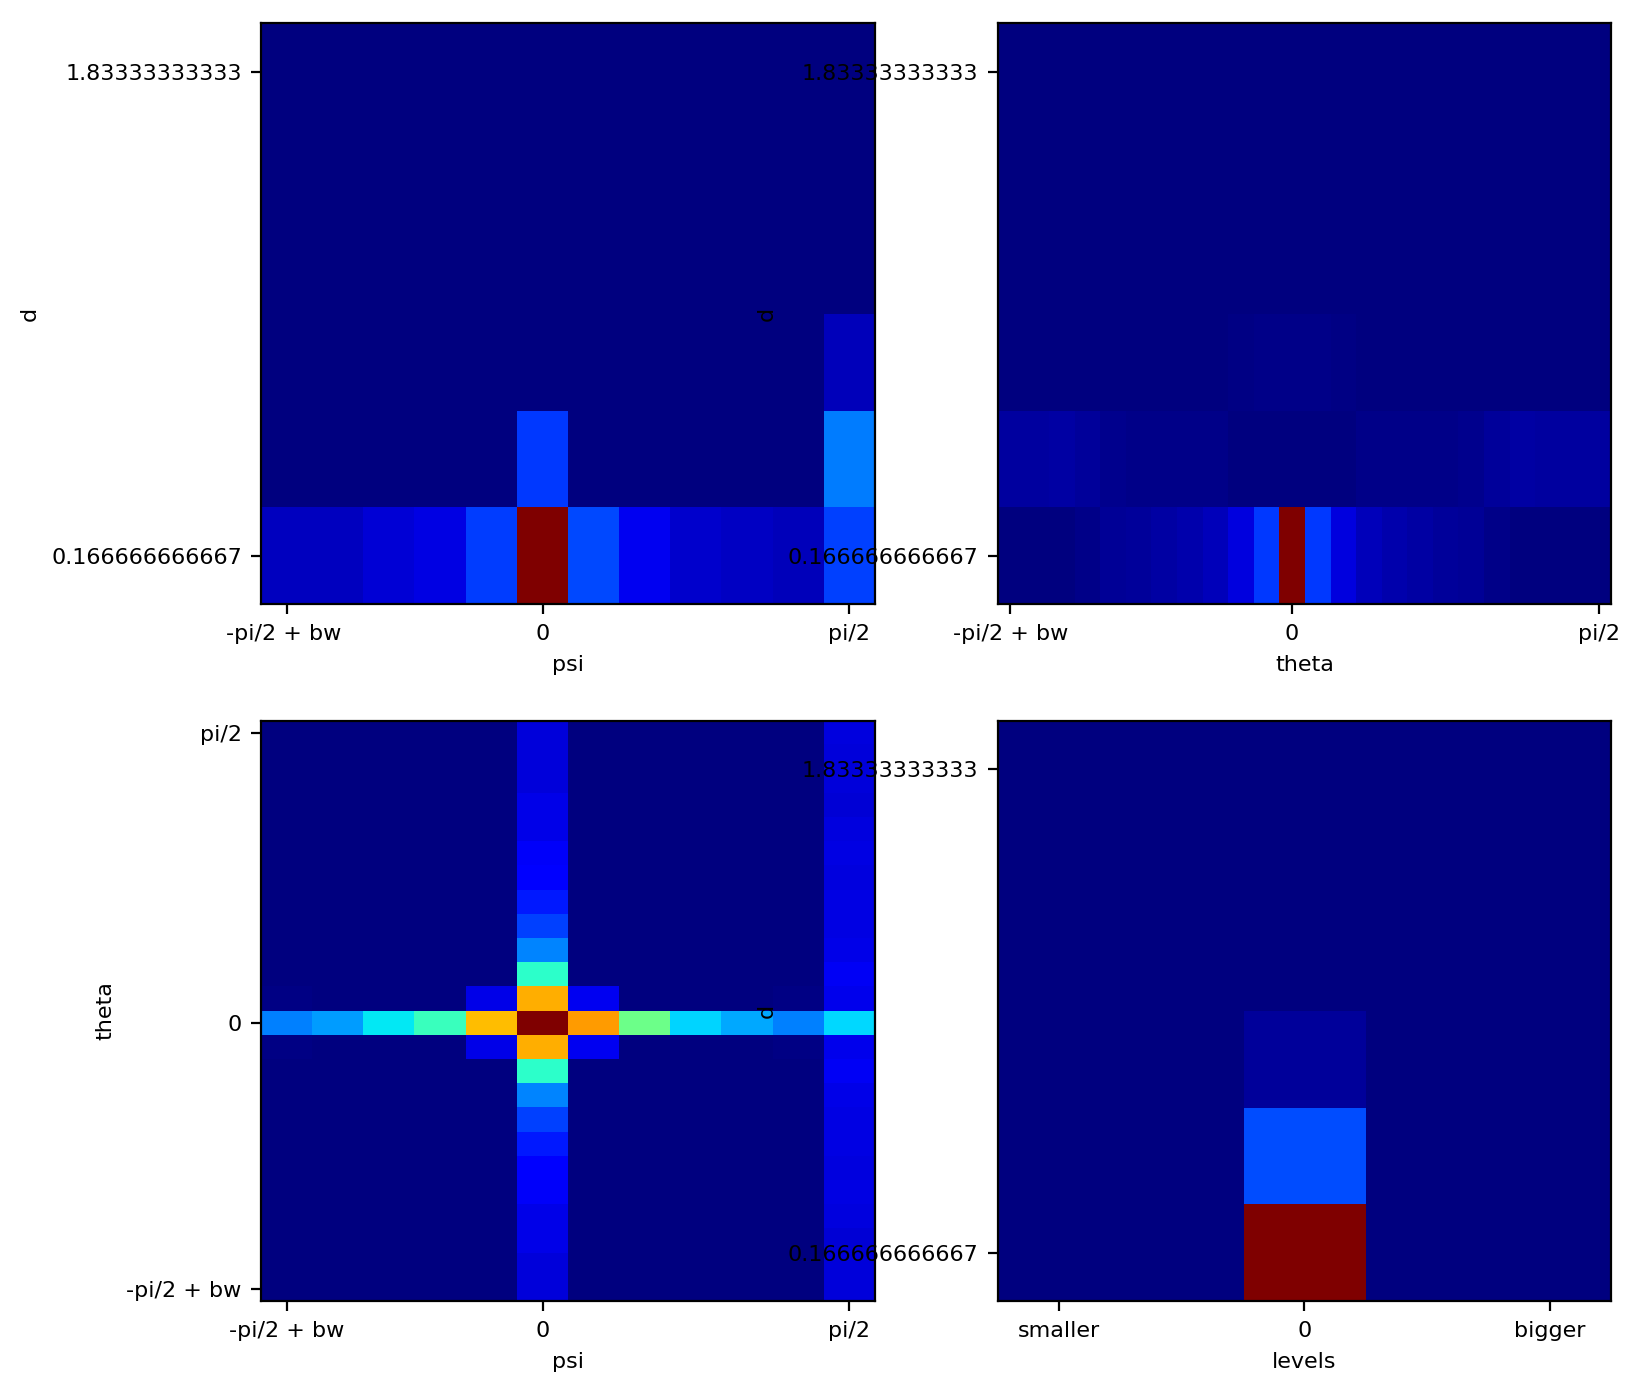

In [49]:
#! cocircular edges:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
#for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N)):
for i_N, angle in enumerate(2*np.pi*np.random.rand(mp.pe.N)):
    edgeslist[0, i_N, :] = mp.pe.N_X/2. - mp.pe.N_X/4.*np.sin(angle) + .5 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.pe.N_X/2. + mp.pe.N_X/4.*np.cos(angle) + .5 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = 0.03
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)#

#### cocircular edges on a wider radius

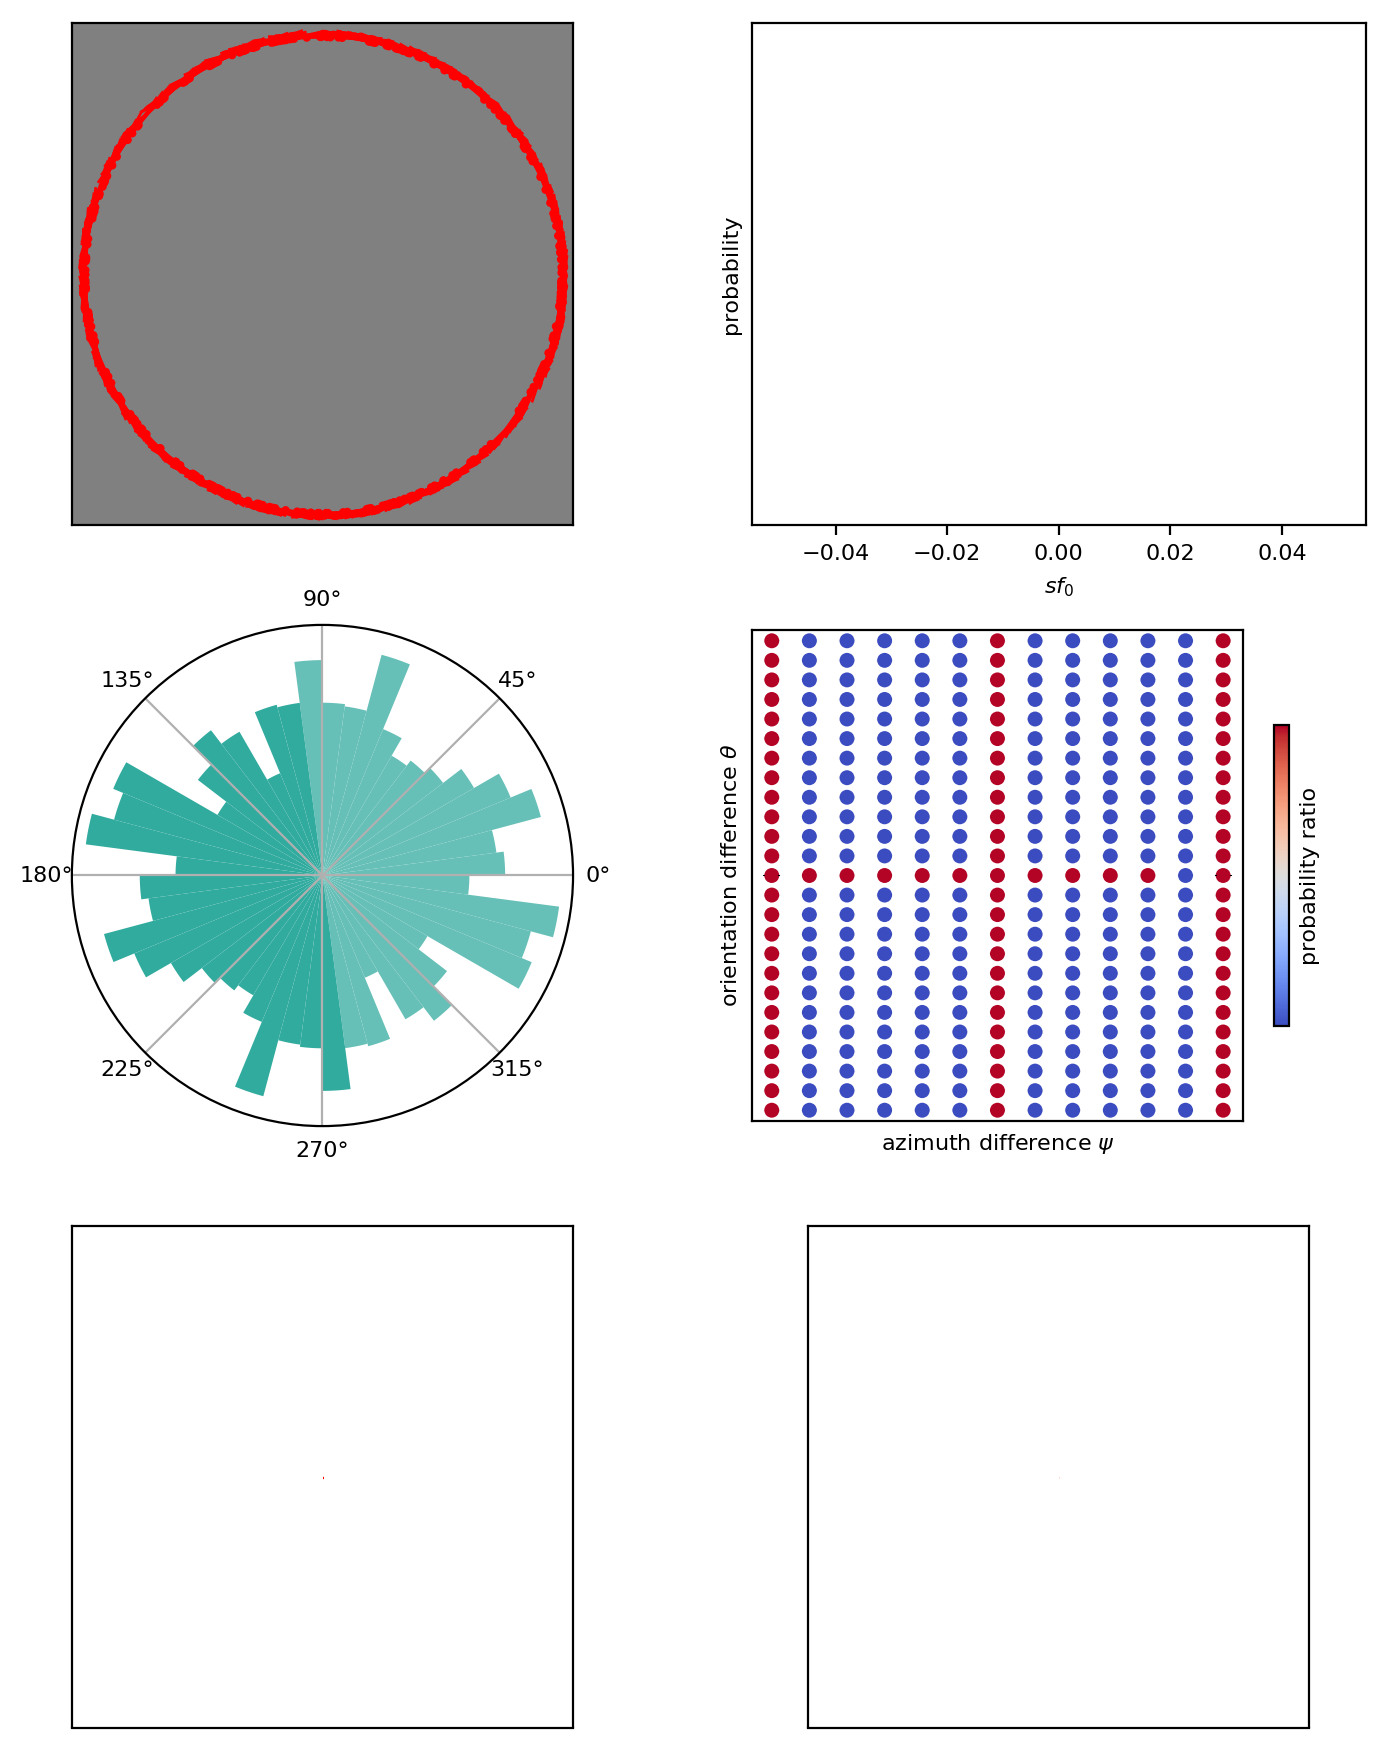

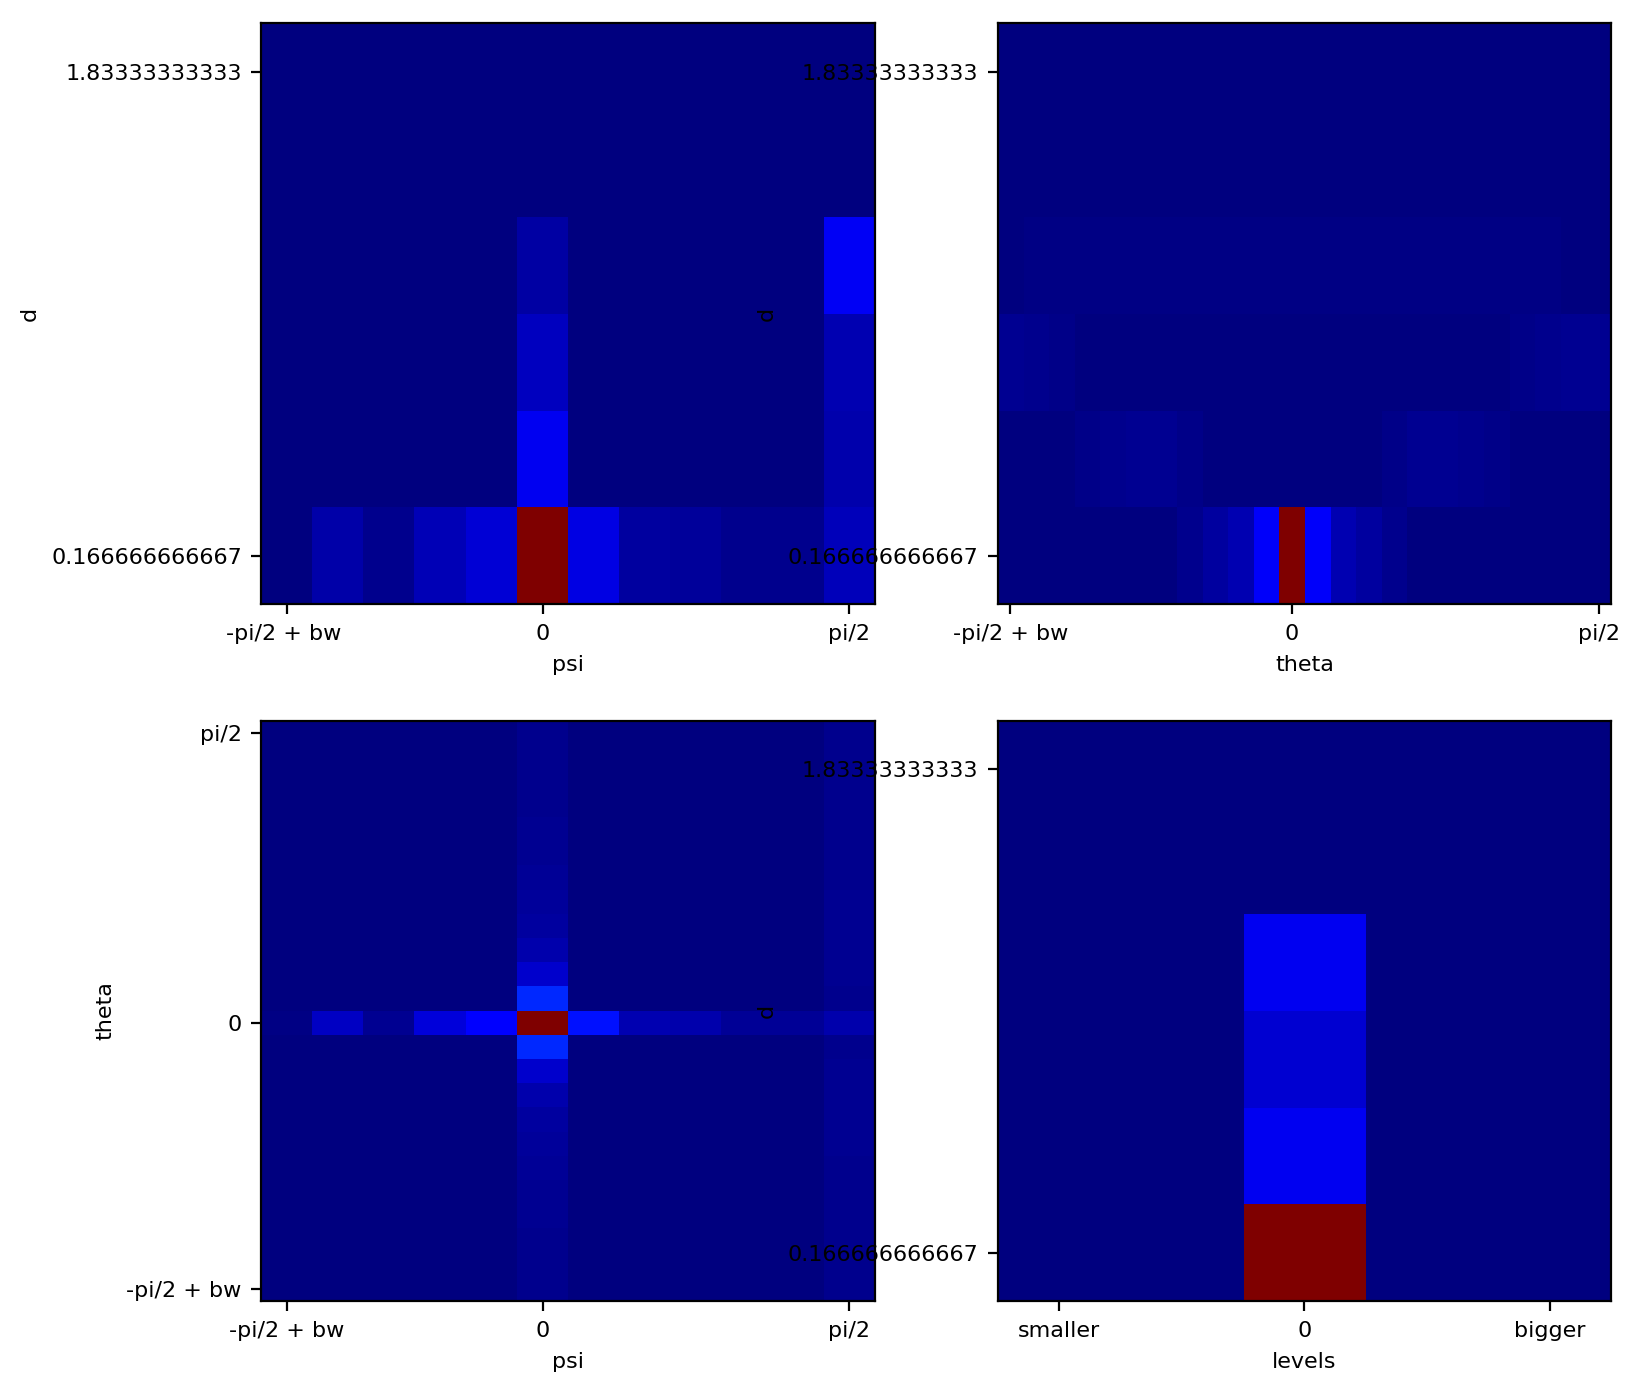

In [50]:
edgeslist = np.zeros((6, mp.pe.N, mp.pe.N_image))
#for i_N, angle in enumerate(np.linspace(0, 2*np.pi, pe.N)):
for i_N, angle in enumerate(2*np.pi*np.random.rand(mp.pe.N)):
    edgeslist[0, i_N, :] = mp.pe.N_X/2. - .95*mp.pe.N_X/2.*np.sin(angle) + .05 * np.random.randn(mp.pe.N_image)
    edgeslist[1, i_N, :] = mp.pe.N_X/2. + .95*mp.pe.N_X/2.*np.cos(angle) + .05 * np.random.randn(mp.pe.N_image)
    edgeslist[2, i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(mp.pe.N_image)) % np.pi
    edgeslist[3, i_N, :] = 0.03
    edgeslist[4, i_N, :] = 1.
_ = myplot(edgeslist, mp=mp)

### real-life examples

In [51]:
mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
help( mp.run_mp)

Help on method run_mp in module SparseEdges.SparseEdges:

run_mp(image, verbose=False, progress=False) method of SparseEdges.SparseEdges.SparseEdges instance
    runs the MatchingPursuit algorithm on image



## some book keeping for the notebook

In [52]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

2016-12-07T11:07:19+01:00

CPython 3.5.2
IPython 5.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.38)
system     : Darwin
release    : 16.1.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [53]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy

Software versions
Python 3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.38)]
IPython 5.1.0
OS Darwin 16.1.0 x86_64 i386 64bit
numpy 1.12.0b1
scipy 0.18.1
matplotlib 2.0.0rc1
sympy 1.0
Wed Dec 07 11:07:19 2016 CET

In [54]:
%cd ../notebooks

/Users/lolo/pool/science/BICV/SparseEdges/notebooks
